In [1]:
%load_ext autoreload
%autoreload 1
%autosave 60

Autosaving every 60 seconds


In [71]:
import sys
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import seaborn as sb
from scipy import stats
from sklearn.decomposition import PCA
import scanpy
from anndata import AnnData
import umap
import anndata
from matplotlib.colors import LogNorm
from difflib import SequenceMatcher
from adjustText import adjust_text
import itertools
import difflib
from Levenshtein import distance as levenshtein_distance
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans


In [3]:
sys.path.append("/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/")

In [4]:
import rnaseq
importlib.reload(rnaseq)

<module 'rnaseq' from '/u/davidm/Documents/Master-thesis/Scripts/RNA-seq/python/rnaseq/__init__.py'>

In [5]:
sample = "Sample_N701_-_Not_Transfected"
new_sample_name = "MCF7-labo-nt"
quant_params = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
# quant_params_trimmed = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/forceCells-3000-noWh"
# quant_params_trimmed_wh = "trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/custom-whitelist"
genref = "human/assembly__GRCh38-hg38/annotation__gencode/gencode_34"
project = "dsp779"
cell_line="MCF7"
cond = "nt"

In [96]:
import matplotlib.scale as mscale
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker

class SquareScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square scale.
    """
 
    name = 'square'
 
    def __init__(self, axis, **kwargs):
        # note in older versions of matplotlib (<3.1), this worked fine.
        # mscale.ScaleBase.__init__(self)

        # In newer versions (>=3.1), you also need to pass in `axis` as an arg
        mscale.ScaleBase.__init__(self, axis)
 
    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())
 
    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax
 
    class SquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform_non_affine(self, a): 
            return np.array(a)**2
 
        def inverted(self):
            return SquareScale.InvertedSquareTransform()
 
    class InvertedSquareTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True
 
        def transform(self, a):
            return np.array(a)
 
        def inverted(self):
            return SquareScale.SquareTransform()
 
    def get_transform(self):
        return self.SquareTransform()

mscale.register_scale(SquareScale)

In [6]:
def hammingDist(str1, str2, fillchar = '-'):
    return sum([ch1 != ch2 for (ch1,ch2) in itertools.zip_longest(str1, str2, fillvalue = fillchar)])

In [7]:
def longest_common_substring(s1, s2):
    set1 = set(s1[begin:end] for (begin, end) in
              itertools.combinations(range(len(s1)+1), 2))
    set2 = set(s2[begin:end] for (begin, end) in
              itertools.combinations(range(len(s2)+1), 2))
    common = set1.intersection(set2)
    maximal = [com for com in common
              if sum((s.find(com) for s in common)) == -1 * (len(common)-1)]
    return [(s, s1.index(s), s2.index(s)) for s in maximal]

In [69]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            barcode = sorting_df.sort_values(by=["total_neighbors", "total_UMIs"], ascending=False).index.values[0]

            whitelist.append(barcode)
            neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
            error_dict[barcode] = list(neighbors)
#             error_dict[barcode] = np.setdiff1d(component, [barcode])

    
    return all_components, error_dict, whitelist

In [88]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    
    for component in all_components :
                
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            sorted_comp = sorting_df.sort_values(by=["total_UMIs"], ascending=False).index.values
            barcode = sorted_comp[0]
            whitelist.append(barcode)
            neighbors = neighbors_mtx.loc[barcode][sorted_comp]
            neighbors = neighbors.index.values[neighbors == 1]
            error_dict[barcode] = neighbors
#             error_dict[barcode] = np.setdiff1d(component, [barcode])

    
    return all_components, error_dict, whitelist

In [9]:
def get_intended_barcodes(errors_dict, barcodes) :
    
    intended_list = []
    errors_list = []
    for intended, erroneous in errors_dict.items(): 
        for barcode in erroneous :
            if barcode in barcodes :
                errors_list.append(barcode)
                intended_list.append(intended)
    
    return np.array(intended_list), np.array(errors_list)

### Plotting parameters

In [10]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 6

### Alevin 

In [11]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params, genref = genref, cdna = "3' tag", exp = "sc")
sc._inplace_subset_obs(np.argsort(sc.obs["raw_cb_freq"].values)[::-1][:3000])
sc.obs_names = sc.obs["CB"]

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.


In [12]:
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "conditions", samples_annot = cond)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "cell_lines", samples_annot = cell_line)
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "source", samples_annot = "labo")
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel())
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
# rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")

rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow=True)

Annotating total_UMIs...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


In [643]:
sc.X.shape

(3000, 20305)

In [94]:
gm = GaussianMixture(2, covariance_type="full")
# clusters_3 = gm.fit_predict((sc.obs["DedupRate"].values).reshape(-1,1)).astype(object)
errors = np.concatenate(list(errors_dict.values()))
# X = np.array([sc.obs["DedupRate"].loc[errors], sc.obs["max_corr"].loc[errors],np.log1p(sc.obs["total_UMIs"].loc[errors])]).T

X = np.array([sc.obs["DedupRate"].loc[errors]]).T

clusters = gm.fit_predict(X).astype(object)

means = pd.DataFrame({"cluster" : clusters, "dedup" : sc.obs["DedupRate"].loc[errors]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)


for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters[clusters == cl] = str(new_cl)
    
    
# sc.obs["cluster_3"] = clusters_3
sc.obs["clusters"] = np.repeat(None, sc.X.shape[0])
# sc.obs["AT"] = np.repeat(False, sc.X.shape[0])
for barcode, cl in zip(errors, clusters) :
    sc.obs["clusters"].loc[barcode] = str(cl)

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


(0.0, 1.0)

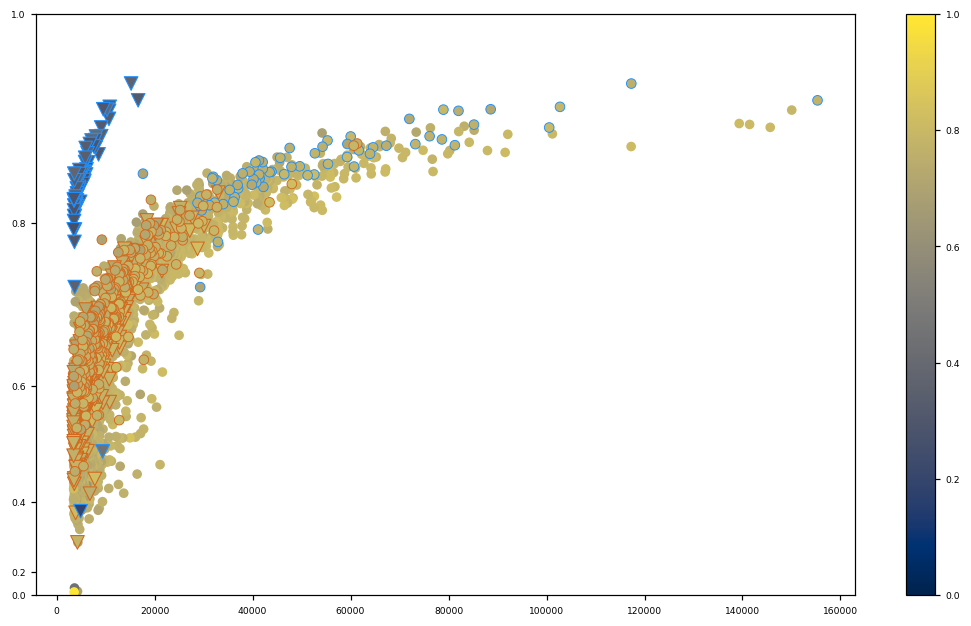

In [109]:
fig, ax = plt.subplots(figsize=(12,7))


errors = np.concatenate(list(errors_dict.values()))
# sc.obs["phred"] = total_scores.mean(1)
# color = "phred"
color = "DedupRate"

vmin = 0
vmax = 1

ax.scatter(sc.obs["raw_cb_freq"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           sc.obs["max_corr"].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], s = 40, \
           c = sc.obs[color].values[[cb not in errors and cb not in errors_dict.keys() for cb in sc.obs_names]], \
           vmin = vmin, vmax = vmax, cmap = "cividis", marker = 'o', linewidths=0, edgecolors='black', zorder = 1)
ax.scatter(sc.obs["raw_cb_freq"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "0"] for cb \
        in sc.obs_names]], s = 40, c = sc.obs[color].values[[cb in errors_dict.keys() and errors_dict[cb][0] \
        in sc.obs_names[sc.obs["clusters"] == "0"] for cb in sc.obs_names]], vmin = vmin, vmax = vmax, cmap = "cividis", \
        marker = 'o', linewidths=0.6, edgecolors='dodgerblue', zorder = 2)
ax.scatter(sc.obs["raw_cb_freq"].values[sc.obs["clusters"] == "1"], sc.obs["max_corr"].values[sc.obs["clusters"] == "1"], \
        s = 80, c = sc.obs[color].values[sc.obs["clusters"] == "1"], vmin = vmin, vmax = vmax, marker = 'v', linewidths=0.7, \
        cmap = "cividis", edgecolors='chocolate', zorder = 3)
scatt = ax.scatter(sc.obs["raw_cb_freq"].values[sc.obs["clusters"] == "0"], sc.obs["max_corr"].values[sc.obs["clusters"] \
        == "0"], s = 80, c = sc.obs[color].values[sc.obs["clusters"] == "0"], vmin = vmin, vmax = vmax, marker = 'v', \
        linewidths=0.7,  cmap = "cividis", edgecolors='dodgerblue', zorder = 4)
ax.scatter(sc.obs["raw_cb_freq"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] \
        == "1"] for cb in sc.obs_names]], sc.obs["max_corr"].values[[cb in errors_dict.keys() and errors_dict[cb][0] in \
        sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], s = 40, c = sc.obs[color].values[[cb \
        in errors_dict.keys() and errors_dict[cb][0] in sc.obs_names[sc.obs["clusters"] == "1"] for cb in sc.obs_names]], \
        vmin = vmin, vmax = vmax, cmap = "cividis", marker = 'o', linewidths=0.6, edgecolors='chocolate', zorder = 5)
fig.colorbar(scatt)


# i = 0
# cbs_2 = []
# for barcode1 in errors :
#     for barcode2 in errors_dict.keys() :
#         if barcode1 in errors_dict[barcode2] : #and barcodes_corr_max.loc[barcode1][0] == barcode2 :
#             if sc.obs["max_corr"].loc[barcode1] < 0.85 and sc.obs["clusters"].loc[barcode1] == "1": # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
#                 cbs_2.append(barcode1)
#                 x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
#                 y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#                 ax.plot(x,y, linewidth = 0.5, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 6, alpha = 0.5)
#                 i += 1
                
# ax.set_xscale("squareroot")
ax.set_yscale("square")
plt.ylim(0,1)

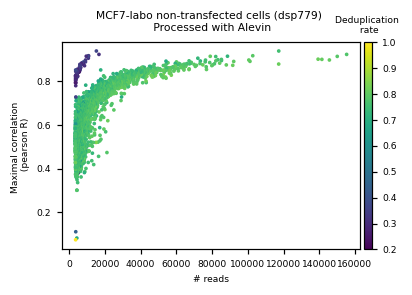

In [681]:
rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["DedupRate"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        color_title = "Deduplication \n rate", save = "./figs/nt-reads-max-corr.pdf", vmax=1, vmin=0.2)

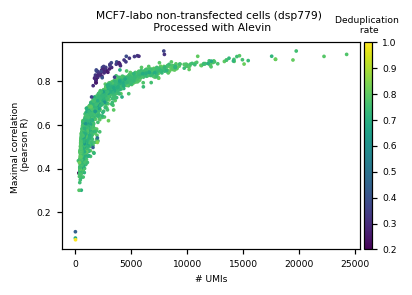

In [791]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["DedupRate"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        color_title = "Deduplication \n rate", save = "./figs/nt-reads-max-corr.pdf", vmax=1, vmin=0.2)

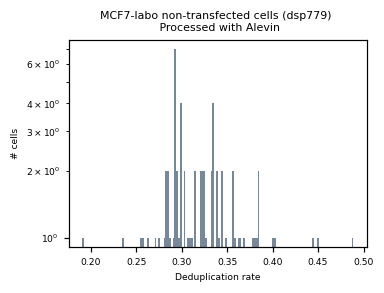

In [816]:
plt.subplots(figsize=(3.5,2.5))

plt.hist(sc.obs["DedupRate"][d==1], bins = 150, color = "lightslategray");
plt.xlabel("Deduplication rate");
plt.ylabel("# cells");
plt.title("MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin")
plt.savefig("./figs/distrib_dedup_nt.svg")
plt.yscale("log")

In [646]:
barcodes = sc.obs["CB"].values

n_neighbors = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]
pd.DataFrame(np.unique(n_neighbors, return_counts=True))

0    1    2    3   4
0     0    1    2    3   4
1  1944  219  196  629  12

### Low dedup population, nearest correlations

In [99]:
low_dedup_barcodes = sc.obs["CB"].values[sc.obs["DedupRate"] < 0.4]
barcodes = sc.obs["CB"].values

i_corr_max = np.argsort(np.corrcoef(sc.X.toarray()), axis = 0)[-2]
barcodes_corr_max = pd.DataFrame(sc.obs["CB"].values[i_corr_max], index = sc.obs["CB"].values)

neighbors_mtx = np.empty((len(low_dedup_barcodes), len(barcodes)))  
for i in range(len(low_dedup_barcodes)) :
    barcode1 = low_dedup_barcodes[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = low_dedup_barcodes, dtype=int)


/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


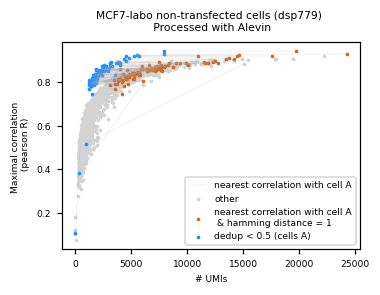

In [108]:
fig, _ = plt.subplots(figsize=(3.5,2.5))

sc.obs["select"] = ["dedup < 0.5 (cells A)" if (d < 0.4) else "other" for d in sc.obs["DedupRate"]]

i = 0
j = 0
for barcode1 in low_dedup_barcodes :
    for barcode2 in barcodes :
        if barcodes_corr_max.loc[barcode1][0] == barcode2 :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "darkgray", label = "nearest correlation with cell A" if i == 0 else "")
            i += 1
            if neighbors_mtx.loc[barcode1][barcode2] == 1 :
                sc.obs["select"][barcode2] = "nearest correlation with cell A\n & hamming distance = 1"
                j +=1
            
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"],\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"dedup < 0.5 (cells A)" : "dodgerblue", "nearest correlation with cell A\n & hamming distance = 1" : "chocolate", "other" : "lightgray"},\
                        order_color = ["other","nearest correlation with cell A\n & hamming distance = 1", "dedup < 0.5 (cells A)"], fig = fig)

plt.legend();

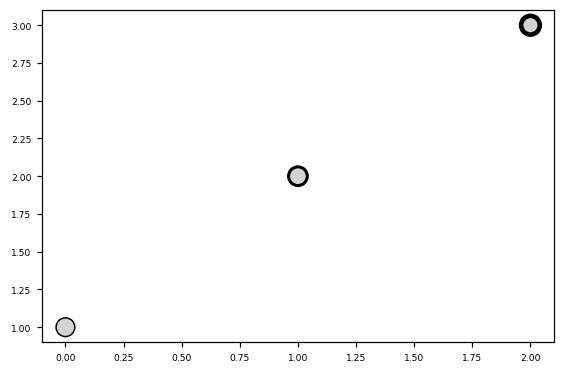

In [1241]:
plt.scatter([0,1,2], [1,2,3], color = "lightgray", s = 150, linewidth=[1,2,3], edgecolor='black')

In [1284]:
# gm = GaussianMixture(3)
# sc.obs["cluster"] = gm.fit_predict(sc.obs["DedupRate"].values.reshape(-1,1)).astype(str)

# i_corr_max = np.argsort(np.corrcoef(sc.layers["log_norm"].toarray()), axis = 0)[-2]
# barcodes_corr_max = pd.DataFrame(sc.obs_names[i_corr_max], index = sc.obs_names)


# sizes = np.array([100 if barcode in np.concatenate([list(errors_dict.keys()), list(errors_dict.values())]) else 150 for barcode in sc.obs_names])
sizes = np.array([100 if barcode in whitelist else 150 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])
# l = np.array([1 if barcode in list(errors_dict.keys()) else 0.4 for barcode in sc.obs_names])
l = np.array([0 if barcode in whitelist else 0.8 for barcode in sc.obs_names])
z =  np.array([1 if barcode in whitelist else 3 for barcode in sc.obs_names])

In [1254]:
l

array([5, 0, 0, ..., 0, 0, 0])

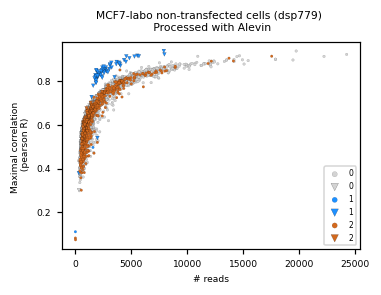

In [1160]:
fig, _ = plt.subplots(figsize=(3.5,2.5))


# i = 0
# for barcode1 in sc.obs_names[sc.obs["cluster"] == '1'] :
#     for barcode2 in sc.obs_names :
#         if barcodes_corr_max.loc[barcode1][0] == barcode2 and hammingDist(barcode1, barcode2) == 1 :
#             x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
#             y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
#             plt.plot(x,y, linewidth = 0.2, color = "darkgray", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2)
#             i += 1
            
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = sizes, color = sc.obs["cluster"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        order_color = 'ascending', \
                        fig = fig, edgecolors='black', linewidth=l, marker = markers, order_marker=['o','v'], \
                        palette = {'1' : "dodgerblue", '2' : "chocolate", '0':"lightgray"},
                        save = "./figs/max-corr-complete.pdf")

# plt.legend();

In [1270]:
np.concatenate(list(errors_dict.values()))

array(['TGGTAACTAGAG', 'TGGTAACTTGAC', 'TGGTAACTTGAA', 'TGGTAACTTGAT',
       'TGGTAACTAGAA', 'TGGTAACTAGAC', 'TGGTAACTAGAT', 'AGGTATACGAAC',
       'AGGTATACGAAA', 'AGGTATACGAAT', 'TGGTATACGAAG', 'GGAGGCACCCTG',
       'GGAGGCATCCTA', 'GGAGGCACCCTT', 'GGAGGCACCCTC', 'CCGTTATTCGGG',
       'CCGTTATTCCGA', 'CCGTTATTCCGC', 'CCGTTATTCCGT', 'AAAACGTCTCAG',
       'AAAACGTCTCAC', 'AAAACGTCTCAT', 'ATAACGTCTCAA', 'CCGATGGTCGCC',
       'CCGATGGTCGCA', 'CCGATGGTCGCT', 'ACGTTTACCGAG', 'ACGTTTACCGAC',
       'ACGTTTACCGAT', 'GACATCGCCAGC', 'GACATCGCCAGA', 'GACATCGCCAGT',
       'GTTGCTCTCAAC', 'GTTGCTCTCAAA', 'GTTGCTCTCAAT', 'CTTCCGTTATTC',
       'CTTCCGTTATTA', 'CTTCCGTTATTT', 'GACGACCATGCC', 'GACGACCATGCA',
       'GACGACCATGCT', 'TTACGCGGGTTC', 'TTACGCGGGTTA', 'TTACGCGGGTTT',
       'CCGAACCCGAAC', 'CCGAACCCGAAA', 'CCGAACCCGAAT', 'GAACATCACGTC',
       'GAACATCACGTA', 'GAACATCACGTT', 'ACGCTCACTGAC', 'ACGCTCACTGAA',
       'ACGCTCACTGAT', 'GATCATGTTACA', 'GATCATGTTACT', 'GATCATGTTACC',
      

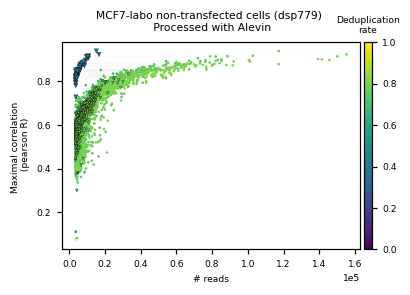

In [1307]:
# sizes = np.array([3 if barcode in whitelist else 8 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])

l = np.array([0 if barcode in whitelist else 0.2 for barcode in sc.obs_names])
# l = np.array([0.3 if barcode in list(errors_dict.keys()) else 0 for barcode in sc.obs_names])
# l = np.array([li if barcode in whitelist else 0.3 for barcode,li in zip(sc.obs_names,l)])

fig, _ = plt.subplots(figsize=(3.5,2.5))


i = 0
big_sizes = []
errors = np.concatenate(list(errors_dict.values()))
# errors_to_corr = sc.
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
            big_sizes.append(barcode1)
            big_sizes.append(barcode2)
            if sc.obs["max_corr"].loc[barcode1] > 0.7 : # < 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
                x = (sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode1], sc.obs["raw_cb_freq"].values[sc.obs["CB"] == barcode2])
                y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
                plt.plot(x,y, linewidth = 0.02, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.25)
                i += 1

sizes = np.array([8 if barcode in big_sizes and barcode not in whitelist else 3 for barcode in sc.obs_names])
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

rnaseq.plotting.scatter(sc.obs["raw_cb_freq"].values, sc.obs["max_corr"].values, s = sizes, color = sc.obs["DedupRate"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", color_title = "Deduplication\nrate",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor='black', linewidth=l, \
                        palette = {'1' : "dodgerblue", '2' : "chocolate", '0':"lightgray"},
                        order_color='ascending', marker=markers, vmin = 0, vmax = 1, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

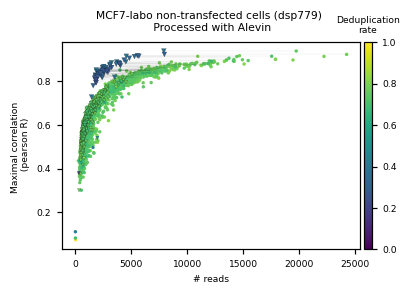

In [1310]:
# sizes = np.array([3 if barcode in whitelist else 8 for barcode in sc.obs_names])
markers = np.array(['o' if barcode in whitelist else 'v' for barcode in sc.obs_names])

l = np.array([0 if barcode in whitelist else 0.1 for barcode in sc.obs_names])
# l = np.array([0.3 if barcode in list(errors_dict.keys()) else 0 for barcode in sc.obs_names])
# l = np.array([li if barcode in whitelist else 0.3 for barcode,li in zip(sc.obs_names,l)])

fig, _ = plt.subplots(figsize=(3.5,2.5))


i = 0
big_sizes = []
errors = np.concatenate(list(errors_dict.values()))
# errors_to_corr = sc.
for barcode1 in errors :
    for barcode2 in errors_dict.keys() :
        if barcode1 in errors_dict[barcode2] and barcodes_corr_max.loc[barcode1][0] == barcode2 :
            big_sizes.append(barcode1)
            big_sizes.append(barcode2)
            if sc.obs["max_corr"].loc[barcode1] > 0.7 : #< 0.9 and sc.obs["max_corr"].loc[barcode1] > 0.85 and sc.obs["raw_cb_freq"].loc[barcode1] > 50000:
                x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
                y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
                plt.plot(x,y, linewidth = 0.08, color = "black", label = "max R & hd =1 with gm1" if i == 0 else "", zorder = 2, alpha=0.3)
                i += 1

sizes = np.array([10 if barcode in big_sizes and barcode not in whitelist else 5 for barcode in sc.obs_names])
                
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = sizes, color = sc.obs["DedupRate"].values,\
                        xlabel = "# reads", ylabel="Maximal correlation \n (pearson R)", color_title = "Deduplication\nrate",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        fig = fig, edgecolor='black', linewidth=l, \
                        palette = {'1' : "dodgerblue", '2' : "chocolate", '0':"lightgray"},
                        order_color='descending', marker=markers, vmin = 0, vmax = 1, order_marker={'o':1,'v':3}, \
                        save = "./figs/max-corr-complete.pdf")

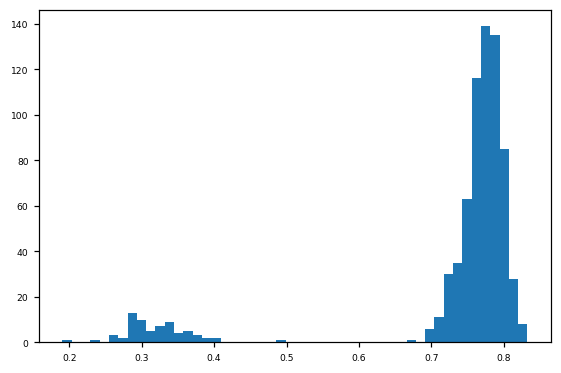

In [1205]:
plt.hist(sc.obs["DedupRate"].loc[np.concatenate(list(errors_dict.values()))], bins = 50);

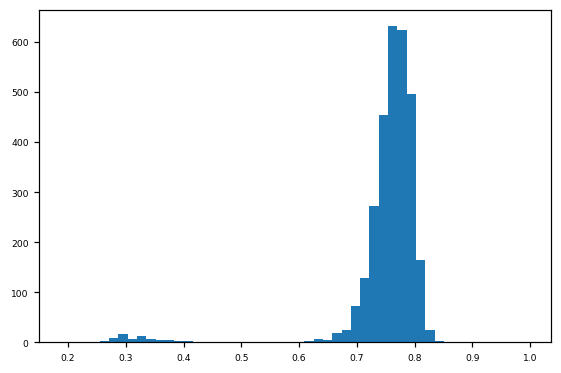

In [1206]:
plt.hist(sc.obs["DedupRate"], bins = 50);

In [112]:
print(f"{j} cells over the {i} low dedup cells have a hamming distance of 1 with its nearest correlating cell.")

95 cells over the 98 low dedup cells have a hamming distance of 1 with its nearest correlating cell.


### All neighbors

In [ ]:
cbs = sc.obs["CB"].values

has_hd1 = []
n_hd1 = []
originals = []
errors = []
max_corr_cb = []

for cb in cbs :
    
    d = np.array([hammingDist(cb, cb2) for cb2 in cbs[cbs != cb]])
    n_hd1.append((d == 1).sum())
    if np.any(d == 1) :      
        has_hd1.append(cb)
        i = np.argsort(np.corrcoef(sc.X.toarray())[sc.obs["CB"] == cb].ravel())[-2]
        
        if sc.obs["CB"][i] in cbs[cbs != cb][d == 1] :
            if sc.obs["MappedReads"].values[sc.obs["CB"] == cb] > sc.obs["MappedReads"].values[i] :
                originals.append(cb)
                errors.append(sc.obs["CB"][i])
            else :
                originals.append(sc.obs["CB"][i])
                errors.append(cb)

In [556]:
np.mean(n_hd1)/(1/500)

192.30769230769232

In [557]:
300/200

1.5

In [313]:
len(has_hd1)

1331

In [313]:
len(has_hd1)

1331

In [1569]:
# sc.obs["has_neighbor"] = np.array(["has neighbor(s)" if cb in has_hd1 else "no neighbor" for cb in cbs] , dtype=str)
barcodes = sc.obs["CB"].values
sc.obs["n_neighbors"] = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]

# rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["has_neighbor"].values,\
#                         xlabel = "# mapped reads", ylabel="Maximal correlation \n (pearson R)",\
#                         title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
#                         color_title = "Selected cells",\
#                         palette = {"has neighbor(s)" : "dodgerblue", "no neighbor":"lightgray"}, order_color="descending")

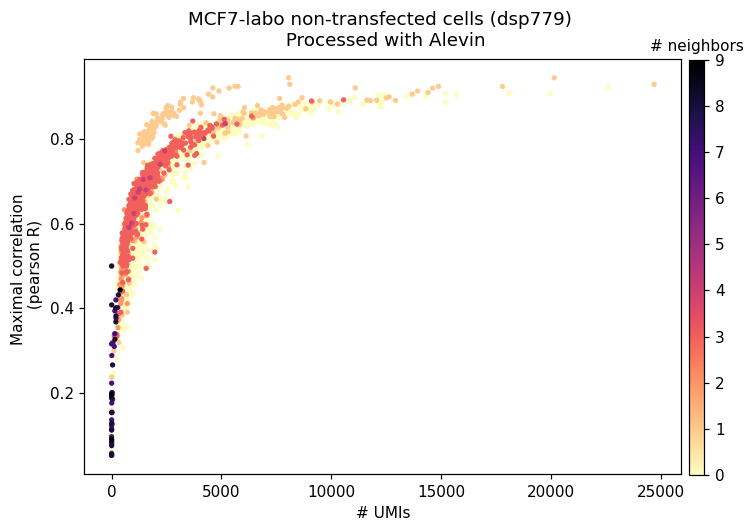

In [1583]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["n_neighbors"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        color_title = "# neighbors", order_color="ascending", palette = "magma_r", save="./figs/nn.png")

In [163]:
i = np.argwhere((np.array(n_hd1) == 9)).ravel()
sc.obs["CB"][i]

824     GACCTGTCTCTT
1098    CACCTGTCTCTT
1602    CGCCTGTCTCTT
Name: CB, dtype: object

In [133]:
i = np.argwhere((np.array(n_hd1) == 8)).ravel()
sc.obs["CB"][i]

1108    GGTCTGTCTCTT
1125    GGCCTGTCTCTT
1170    GCCCTGTCTCTT
1188    GGGCTGTCTCTT
1224    CCCCTGTCTCTT
1260    GTGCTGTCTCTT
1268    GATCTGTCTCTT
1270    GGACTGTCTCTT
1323    GCTCTGTCTCTT
1359    GTCCTGTCTCTT
1434    AGTCTGTCTCTT
1461    GTTCTGTCTCTT
1550    ATTCTGTCTCTT
1553    CATCTGTCTCTT
1721    GCGCTGTCTCTT
1785    GAACTGTCTCTT
1855    CGTCTGTCTCTT
1936    AGACTGTCTCTT
1981    GCACTGTCTCTT
2179    CCGCTGTCTCTT
2350    CCTCTGTCTCTT
2485    CGGCTGTCTCTT
Name: CB, dtype: object

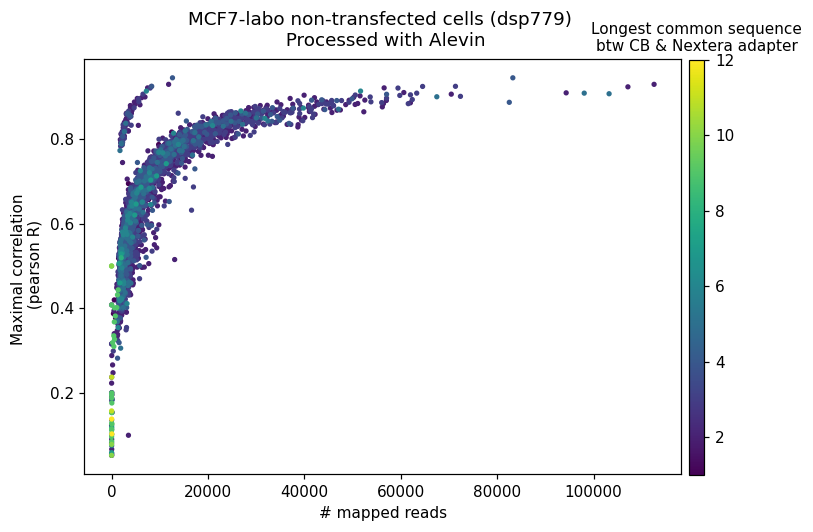

In [449]:
adapter = "CTGTCTCTTATACACATCTC"

sc.obs["adapter-in-cb"] = [len(longest_common_substring(adapter, cb)[0][0]) for cb in sc.obs["CB"]]

rnaseq.plotting.scatter(sc.obs["MappedReads"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["adapter-in-cb"].values,\
                        xlabel = "# mapped reads", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        color_title = "Longest common sequence\nbtw CB & Nextera adapter", order_color = "ascending")

In [158]:
(np.array(n_hd1) > 3).sum()

59

In [144]:
i = np.argwhere((np.array(n_hd1) > 4)).ravel()
sc.obs["CB"][i]

390     AGGTATACGAAG
476     TGGTAACTTGAG
765     TACCTGTCTCTT
984     TGGTAACTAGAG
1107    CGCCTGTCTGTT
1281    TGGTAACTTGAC
1346    AAAACGTCTCAA
1440    TGGTAACTTGAA
1606    TGGTAACTAGAA
1796    TGGTAACTAGAC
2041    CCGTTATTCCGG
2086    TGGTAACTAGAT
2364    TGGTAACTTGAT
3138    GGAGGCACCCTA
Name: CB, dtype: object

### Connected components

In [14]:
def DFS(neighbors_mtx, component, barcode, visited):

    visited[barcode] = True
    component.append(barcode)
    
    neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
    for neighbor in neighbors :
        if visited[neighbor][0] == False:
            component = DFS(neighbors_mtx, component, neighbor, visited)
    return component


def connectedComponents(neighbors_mtx) :
    
    barcodes = neighbors_mtx.index.values
    visited = pd.DataFrame([np.repeat(False, len(barcodes))], columns = barcodes, index = ["visited"])
    all_components = []

    for barcode in barcodes :
        if visited[barcode][0] == False:
            component = []
            all_components.append(DFS(neighbors_mtx, component, barcode, visited))
    
    i = np.argsort([len(c) for c in all_components])[::-1]
    
    return np.array(all_components, dtype = object)[i]



In [209]:
barcodes = sc.obs["CB"].values

neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs["CB"].values[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)

connected_components = connectedComponents(neighbors_mtx)

In [210]:
sizes_distr = np.unique([len(c) for c in connected_components], return_counts = True)
pd.DataFrame(sizes_distr, index = ["connected component size", "# connected components"]).T

connected component size  # connected components
0                         1                    2663
1                         2                     139
2                         3                      62
3                         4                     197
4                         5                       4
5                         8                       1
6                        51                       1

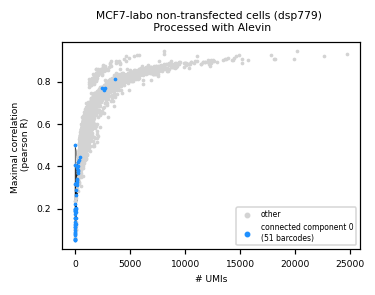

In [214]:
fig,_ = plt.subplots(figsize=(3.5,2.5))

i = 0

component = connected_components[i]

select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black", zorder=2)
            explored.append({barcode1, barcode2})

    
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig, zorders=[1,3])

plt.savefig("./cluster_error.pdf")

plt.show()

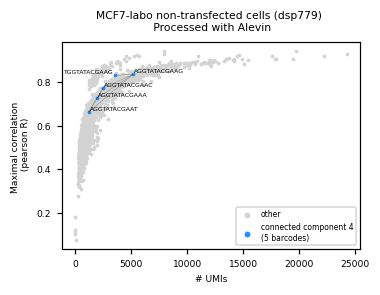

In [166]:
fig,_ = plt.subplots(figsize=(3.5,2.5))

i = 4

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in component :
        select.append(f"connected component {i}\n({len(component)} barcodes)")
    else :
        select.append("other")   

sc.obs["select"] = np.array(select, dtype=str)
explored = []
for barcode1 in component :
    for barcode2 in component :
        if hammingDist(barcode1, barcode2) == 1 and {barcode1,barcode2} not in explored :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "black")
            explored.append({barcode1, barcode2})
    texts.append(plt.text(sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], barcode1, fontsize = 4))


rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {f"connected component {i}\n({len(component)} barcodes)" : "dodgerblue", "other":"lightgray"},\
                        order_color = ["other", f"connected component {i}\n({len(component)} barcodes)"], fig = fig)
adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

CACGACGAGCGG, GACGACGAGCGG
GACGACGAGCGG, CACGACGAGCGG
TGGTAACTTGAG, TGGTAACTAGAG
TGGTAACTAGAG, TGGTAACTTGAG


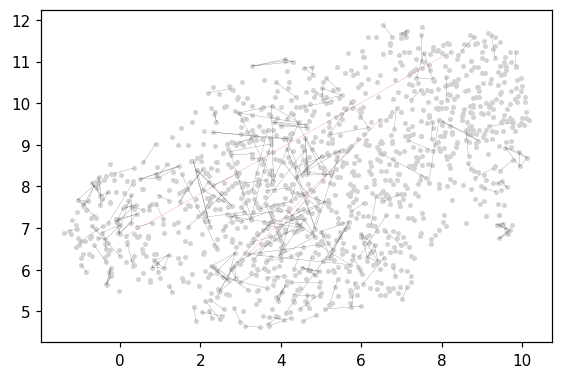

In [1077]:
plt.scatter(sc.obsm["X_umap"].T[0], sc.obsm["X_umap"].T[1], color="lightgray", s=5)

cbs = sc.obs.loc[sc.obs["louvain"] == "11"]["CB"]

for c in sc.obs["CB"].values :
    for c2 in sc.obs["CB"].values :
        if hammingDist(c, c2) == 1 :
            x = (sc.obsm["X_umap"].T[0][sc.obs["CB"] == c], sc.obsm["X_umap"].T[0][sc.obs["CB"] == c2])
            y = (sc.obsm["X_umap"].T[1][sc.obs["CB"] == c], sc.obsm["X_umap"].T[1][sc.obs["CB"] == c2])
            dist = np.sqrt((x[0]-x[1])**2 + (y[0]-y[1])**2)
            if dist > 4 :
                plt.plot(x,y, linewidth = 0.05, color = "red")
                print(f"{c}, {c2}")
            else :
                plt.plot(x,y, linewidth = 0.05, color = "black")

plt.savefig("umap.pdf")

### Nextera adapter

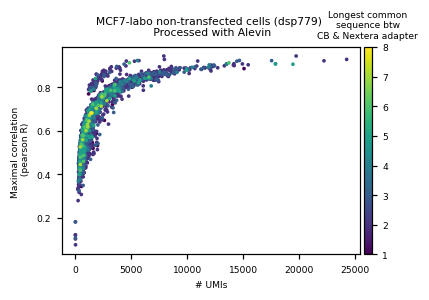

In [155]:
adapter = "CTGTCTCTTATACACATCTC"

sc.obs["adapter-in-cb"] = [len(longest_common_substring(adapter, cb)[0][0]) for cb in sc.obs["CB"]]

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["adapter-in-cb"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        color_title = "Longest common\nsequence btw\nCB & Nextera adapter", order_color = "ascending")

### Dropseq tools

### Alevin trimmed

In [10]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_trimmed, genref = genref, cdna = "3' tag", exp = "sc")

rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")

# rnaseq.pp.filter_cells(sc, n_counts_min = 1500, mt_max = 0.05, inplace = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow=True)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating samples...
Annotating total_UMIs...
Annotating #_genes...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


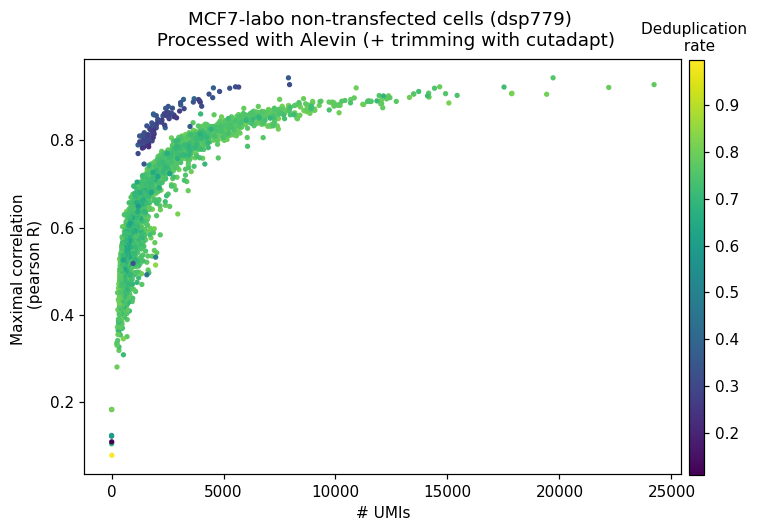

In [453]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["DedupRate"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin (+ trimming with cutadapt)",\
                        color_title = "Deduplication \n rate", save = "./figs/trimmed-nt.svg")

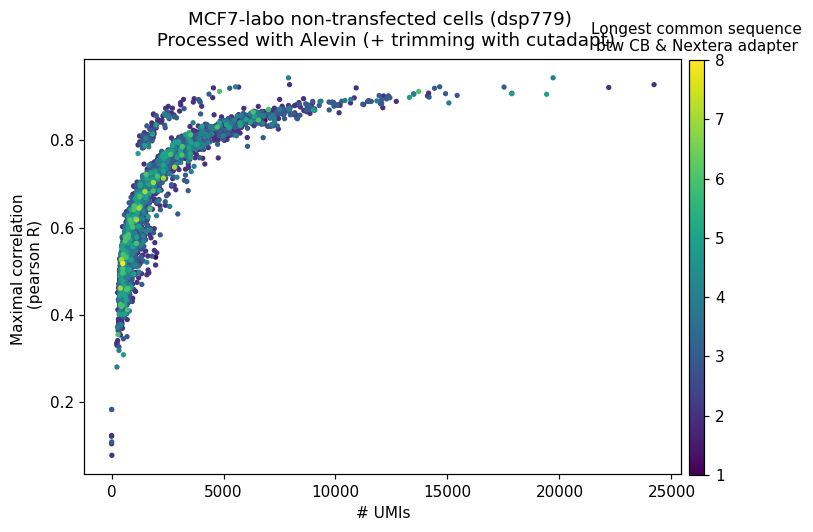

In [967]:
adapter = "CTGTCTCTTATACACATCTC"

sc.obs["adapter-in-cb"] = [len(longest_common_substring(adapter, cb)[0][0]) for cb in sc.obs["CB"]]

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["adapter-in-cb"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin (+ trimming with cutadapt)",\
                        color_title = "Longest common sequence\nbtw CB & Nextera adapter", order_color = "ascending")

### Error patterns

In [817]:
def plot_errors_v1(connected_components, barcodes) :
    
    fig, ax = plt.subplots(figsize = (3.5,2.5))

    ind = np.arange(12) 
    error_pos = [{"A": 0, "T": 0, "G": 0, "C": 0} for _ in ind]

        
    for component in connected_components :
        
        if len(component) > 1 :
            
            n_reads = sc.obs[[(barcode in component) and (barcode in barcodes) for barcode in sc.obs_names]]["raw_cb_freq"].values
            nucleotides_per_position = np.array([list(c) for c in np.intersect1d(component, barcodes)]).T

            for i, (nts_pos,r) in enumerate(zip(nucleotides_per_position, np.repeat([n_reads], 12, axis=0))) :
                if len(np.unique(nts_pos)) > 1 :
                    for nt in error_pos[i].keys() :
                        error_pos[i][nt] += np.sum(r[nts_pos == nt])
    
    
    counts = np.array([list(error_pos[i].values()) for i in ind])

    width = 0.35
    bottom = 0
    for c in np.array(counts).T :
        ax.bar(ind, c, width = 0.25, bottom = bottom)
        bottom += c

    ax.legend(labels = error_pos[0].keys())
    plt.xticks(ind, labels = ind+1)
    plt.show()

In [827]:
def plot_errors(errors_dict, barcodes, weight_by_lib = True) :
    
    nucleotides = ["A","T","G","C"]
    substitutions = {f"{pos}-{nt1}": {nt2 : 0 for nt2 in nucleotides} for pos in np.arange(1,13) for nt1 in nucleotides}


    for barcode1 in errors_dict.keys() :
        for barcode2 in errors_dict[barcode1] :
            if barcode2 not in barcodes :
                continue
            pos = [i for i in range(len(barcode1)) if barcode1[i] != barcode2[i]][0]
            nt1 = list(barcode1)[pos]
            nt2 = list(barcode2)[pos]
            if weight_by_lib :
                substitutions[f"{pos+1}-{nt1}"][nt2] += sc.obs["raw_cb_freq"].loc[barcode2]
            else :
                substitutions[f"{pos+1}-{nt1}"][nt2] += 1
    
    counts = np.array([list(list(substitutions.values())[i].values()) for i in np.arange(48)])
    fig, ax = plt.subplots(figsize=(5.5,2.5))
    bottom = 0
    for c in counts.T :
        ax.bar(np.arange(48), c, width = 0.7, bottom = bottom)
        bottom += c

    ax.legend(labels = nucleotides)
    plt.xticks(np.arange(48), labels = substitutions.keys(), rotation = 90)
    plt.ylim(0,np.max(bottom)+np.max(bottom)/30)
    plt.show()

In [821]:
len(errors_low_dedup)

68

In [714]:
len(errors_normal_dedup)

657

In [1163]:
(sc.obs["MappedReads"] / sc.obs["DeduplicatedReads"]).mean()

4.304781327688527

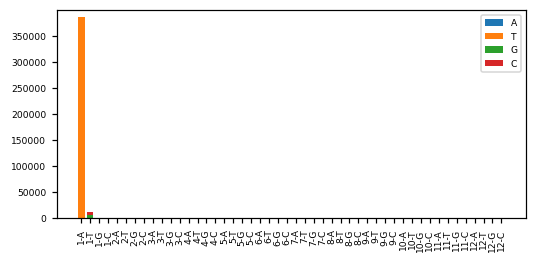

In [828]:
plot_errors(errors_dict, errors_low_dedup)

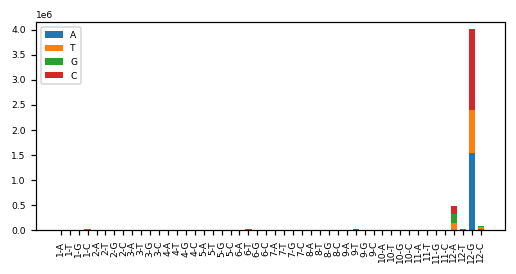

In [930]:
plot_errors(errors_dict, errors_normal_dedup)

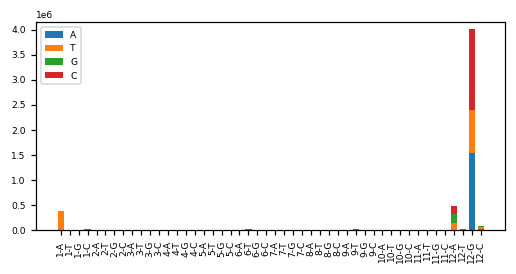

In [1161]:
plot_errors(errors_dict, sc.obs_names)

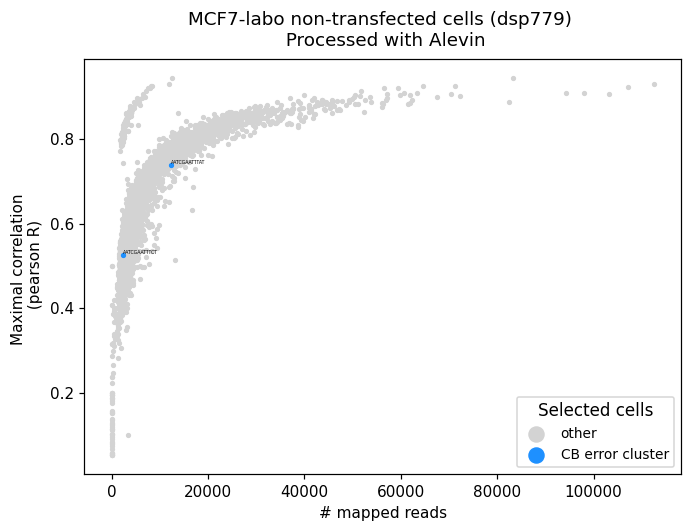

In [561]:
# {'AAAACGTCTCAC', 'ATAACGTCTCAA', 'AAAACGTCTCAG', 'AAAACGTCTCAT', 'AAAACGTCTCAA'},
# {'GGAGGCACCCTT', 'GGAGGCACCCTC', 'GGAGGCACCCTA', 'GGAGGCACCCTG', 'GGAGGCATCCTA'},
# {'AGGTATACGAAA', 'TGGTATACGAAG', 'AGGTATACGAAT', 'AGGTATACGAAC', 'AGGTATACGAAG'},
# {'CCGTTATTCCGA', 'CCGTTATTCCGT', 'CCGTTATTCCGC', 'CCGTTATTCGGG', 'CCGTTATTCCGG'},
# {'CTGCTGTCTCTT', 'AATCTGTCTCTT', 'GAGCTGTCTCTT', 'CACCTGTCTCTT', 'AGGCTGTCTCTT', 'GAACTGTCTCTT', 'CCCCTGTCTCTT', 'CATCTGTCTCTT', 'GACCTGTCTCTT', 'GCCCTGTCTCTT', 'GGTCTGTCTCTT', 'CGTCTGTCTCTT', 'ACACTGTCTCTT', 'TACCTGTCTCTT', 'CAACTGTCTCTT', 'AACCTGTCTCTT', 'AAACTGTCTCTT', 'ATACTGTCTCTT', 'AGCCTGTCTCTT', 'ACGCTGTCTCTT', 'GTTCTGTCTCTT', 'GCTCTGTCTCTT', 'GCGCTGTCTCTT', 'CGACTGTCTCTT', 'AGTCTGTCTCTT', 'GATCTGTCTCTT', 'GTCCTGTCTCTT', 'AGACTGTCTCTT', 'ATTCTGTCTCTT', 'GCACTGTCTCTT', 'CCTCTGTCTCTT', 'GGCCTGTCTCTT', 'CGCCTGTCTGTC', 'CGCCTGTCTGTT', 'GTGCTGTCTCTT', 'CCACTGTCTCTT', 'CTTCTGTCTCTT', 'CGCCTGTCTGTA', 'ATCCTGTCTCTT', 'GGGCTGTCTCTT', 'ATGCTGTCTCTT', 'CGCCTGTCTCTT', 'ACTCTGTCTCTT', 'GGACTGTCTCTT', 'CCGCTGTCTCTT', 'TCCCTGTCTCTT', 'CTCCTGTCTCTT', 'GTACTGTCTCTT', 'CGCCTGTCTGTG', 'CAGCTGTCTCTT', 'CGGCTGTCTCTT'}
# {'AATCGAATTTAT', 'AATCGAATTTCT'}
# {'CATCAGATGGGC', 'CACCAGATGGGC'}
# {'GAATCGACGTAC', 'GATTCGACGTAC'}
# {'CGCGCGGCGCTA', 'CGCGGGGCGCTA'}

cbs = {'AATCGAATTTAT', 'AATCGAATTTCT'}
# get_clusters("TGGTAACTTGAG")
# cbs = clusters[0]

texts = []
select_cluster = []
for c in sc.obs["CB"] :
    if c in cbs :
        select_cluster.append("CB error cluster")
    else :
        select_cluster.append("other")   

sc.obs["select_cluster"] = np.array(select_cluster, dtype=str)

rnaseq.plotting.scatter(sc.obs["MappedReads"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["select_cluster"].values,\
                        xlabel = "# mapped reads", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        color_title = "Selected cells", save = f"./figs/nt-reads-max-corr_population-max-corr-{cb}.svg",\
                        palette = {"CB error cluster" : "dodgerblue", "other":"lightgray"}, order_color = "descending")


for c in sc.obs["CB"] :
    if c in cbs :
        texts.append(plt.text(sc.obs["MappedReads"].values[sc.obs["CB"] == c], sc.obs["max_corr"].values[sc.obs["CB"] == c], c, fontsize = 3))

adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/adjustText/__init__.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_in = np.logical_and(x>x1, x<x2)
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/adjustText/__init__.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_in = np.logical_and(y>y1, y<y2)


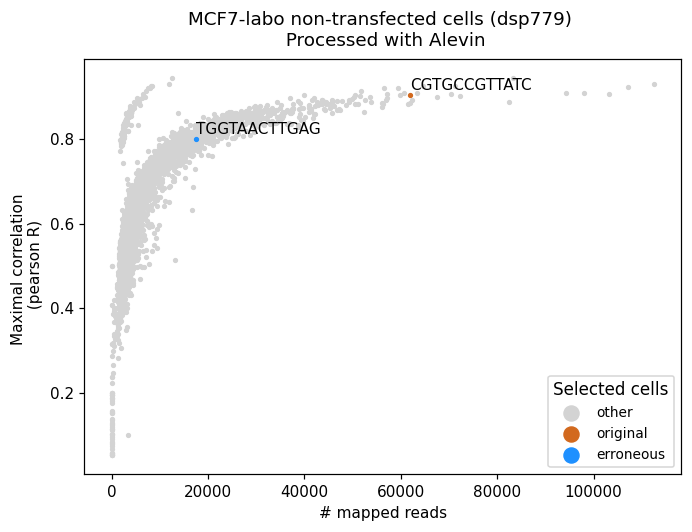

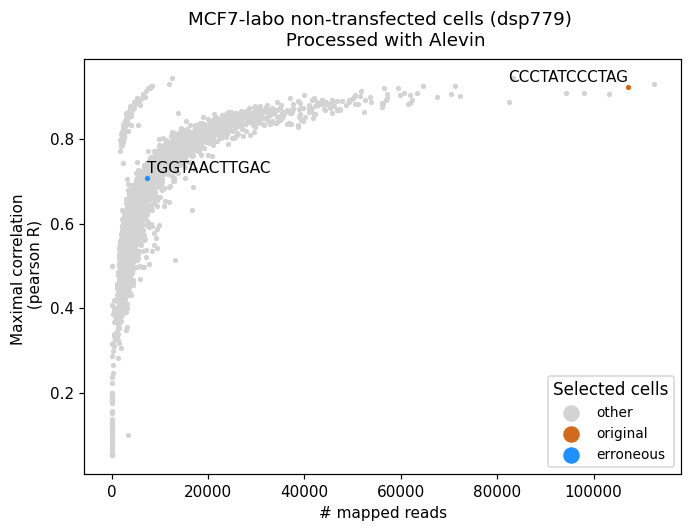

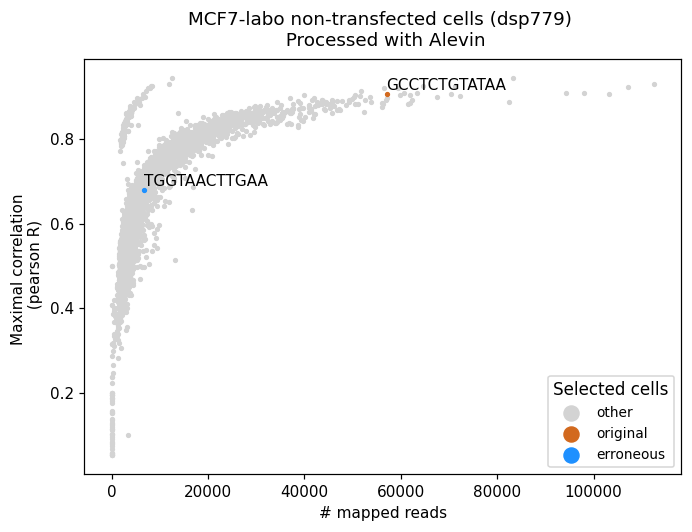

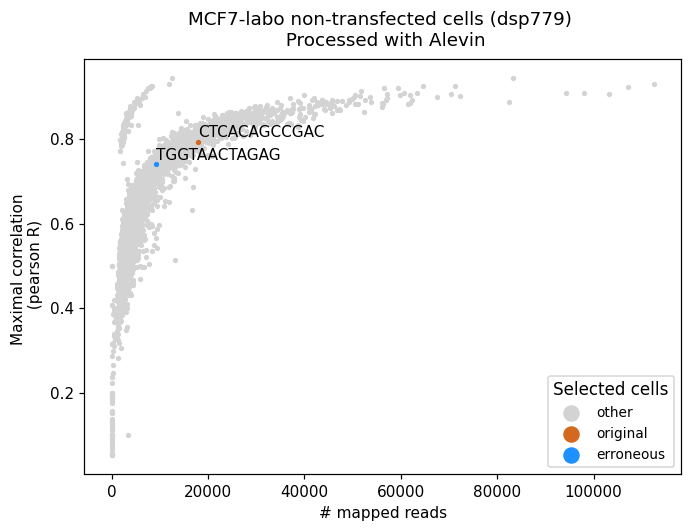

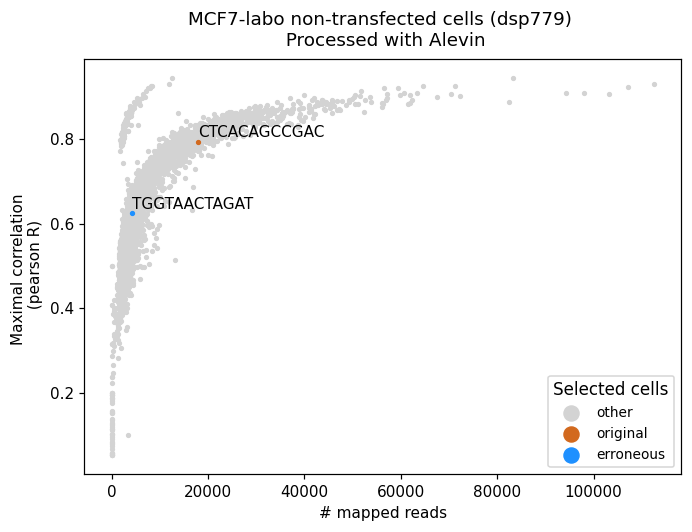

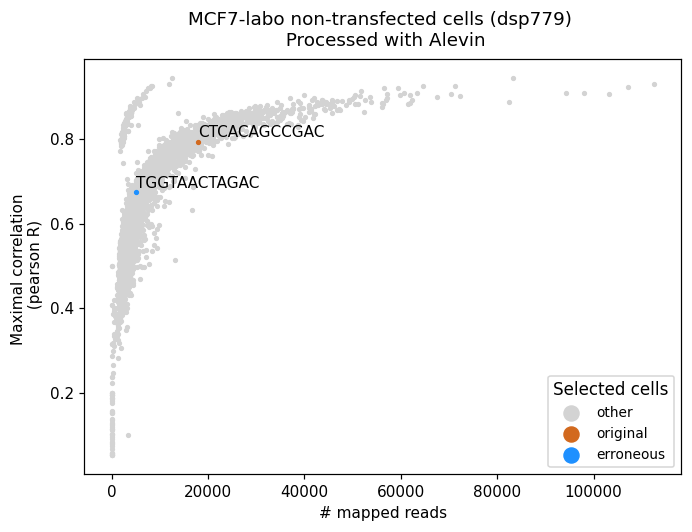

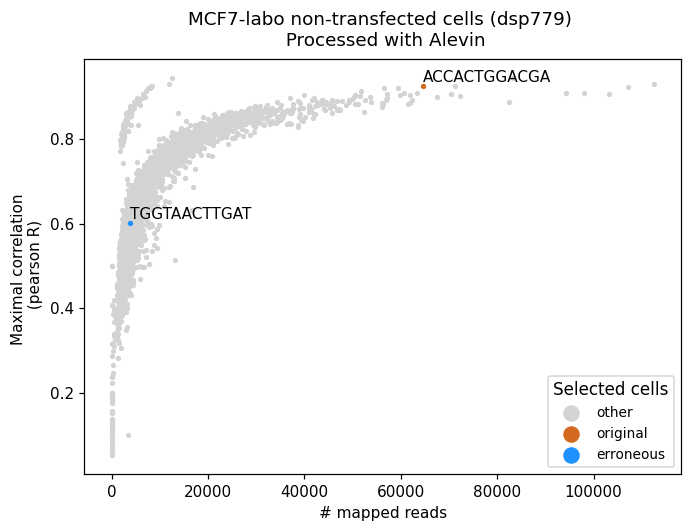

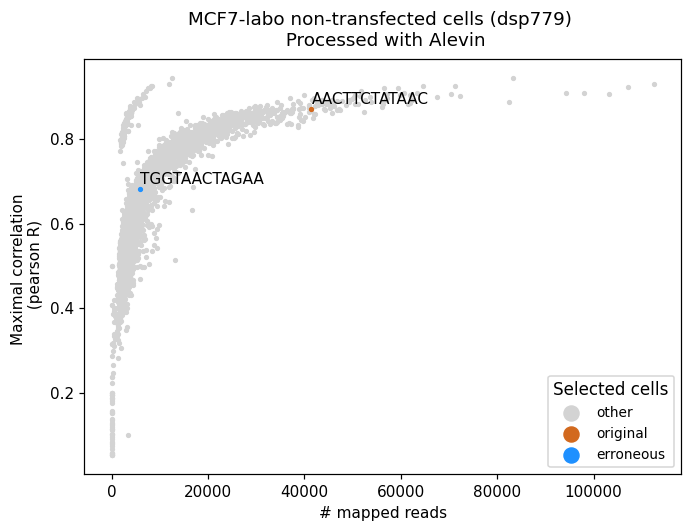

In [329]:
l = {'TGGTAACTTGAG', 'TGGTAACTTGAC', 'TGGTAACTTGAA', 'TGGTAACTAGAG', 'TGGTAACTAGAT', 'TGGTAACTAGAC', 'TGGTAACTTGAT', 'TGGTAACTAGAA'}

for cb in l :
    i = np.argsort(np.corrcoef(sc.X.toarray())[sc.obs["CB"] == cb].ravel())[-2]


    texts = []
    select_one = []
    for c in sc.obs["CB"] :
        if c == cb :
            select_one.append("erroneous")
        elif c == sc.obs["CB"][i] :
            select_one.append("original")
        else :
            select_one.append("other")   

    sc.obs["select_one"] = np.array(select_one, dtype=str)

    rnaseq.plotting.scatter(sc.obs["MappedReads"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["select_one"].values,\
                            xlabel = "# mapped reads", ylabel="Maximal correlation \n (pearson R)",\
                            title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                            color_title = "Selected cells", save = f"./figs/nt-reads-max-corr_population-max-corr-{cb}.svg",\
                            palette = {"erroneous" : "dodgerblue", "original":"chocolate", "other":"lightgray"}, order_color = "descending")


    for c in sc.obs["CB"] :
        if c == cb :
            texts.append(plt.text(sc.obs["MappedReads"].values[sc.obs["CB"] == cb], sc.obs["max_corr"].values[sc.obs["CB"] == cb], c))
        elif c == sc.obs["CB"][i] :
            texts.append(plt.text(sc.obs["MappedReads"].values[i], sc.obs["max_corr"].values[i], c))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'})
    plt.show()

/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/adjustText/__init__.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_in = np.logical_and(x>x1, x<x2)
/u/davidm/VirtualEns/python_3.6.8/lib64/python3.6/site-packages/adjustText/__init__.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  y_in = np.logical_and(y>y1, y<y2)


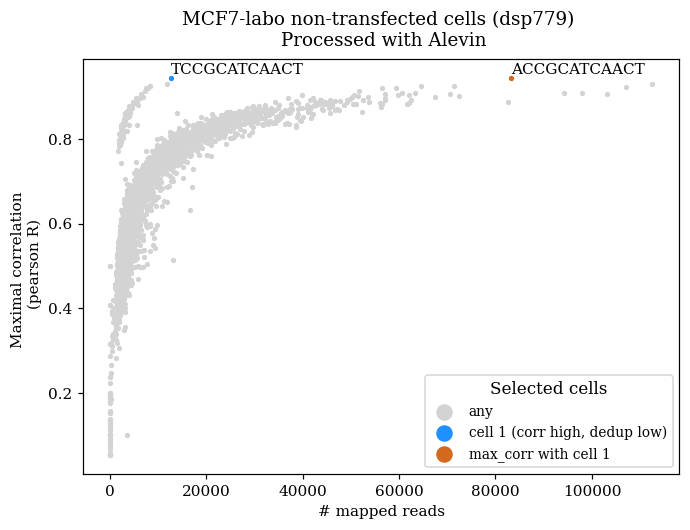

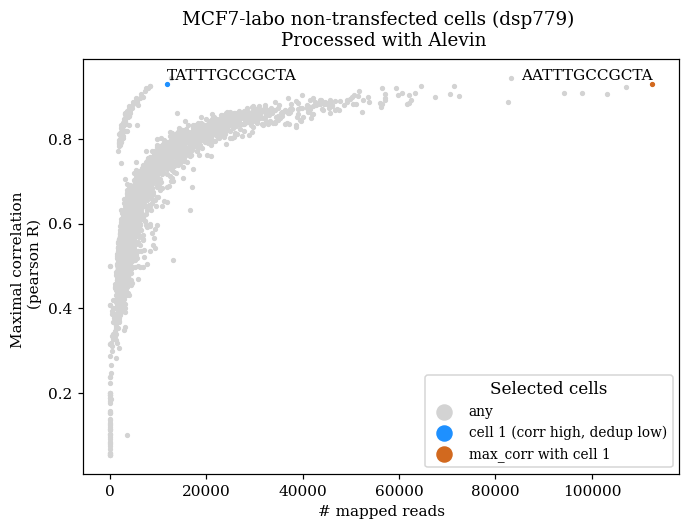

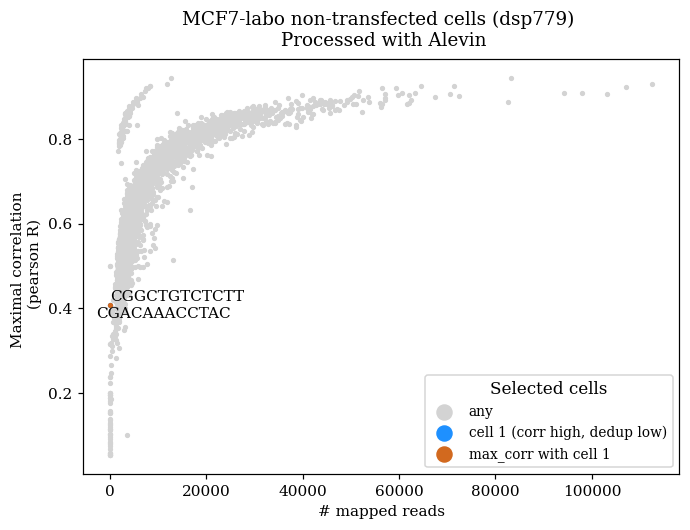

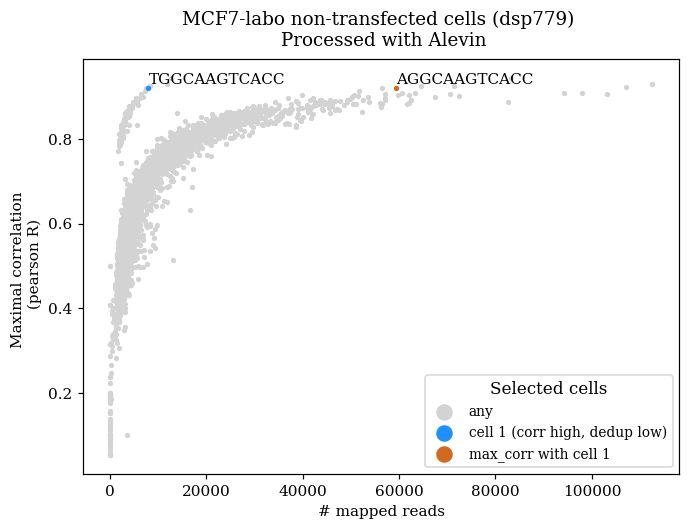

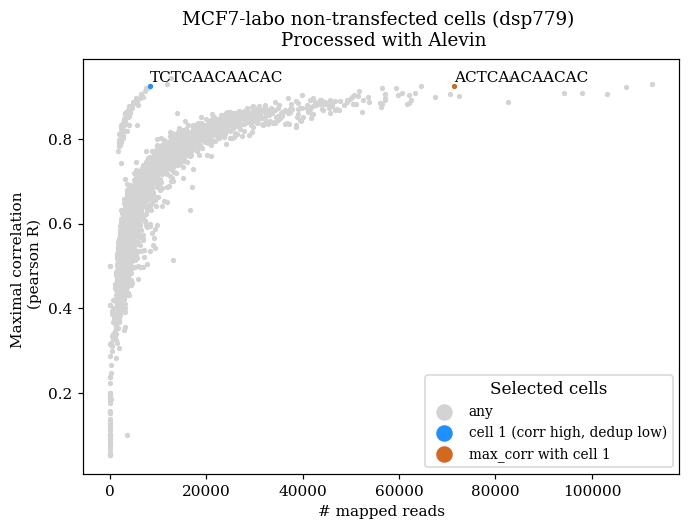

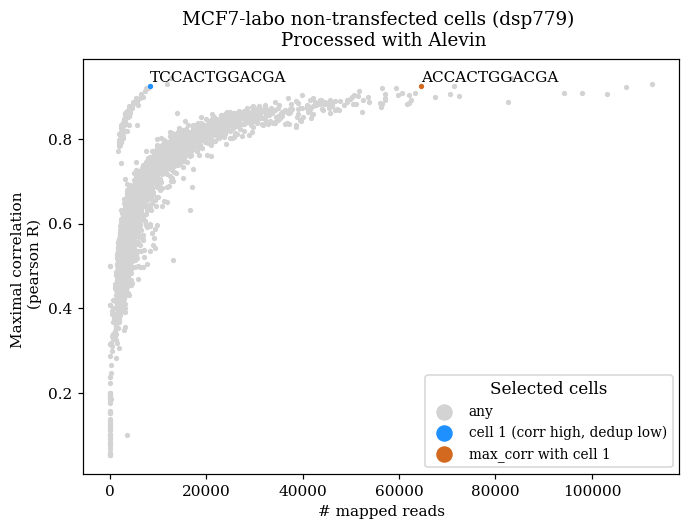

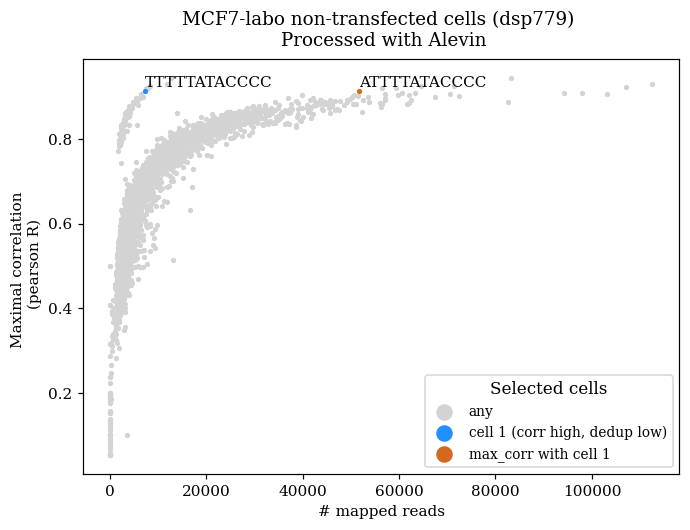

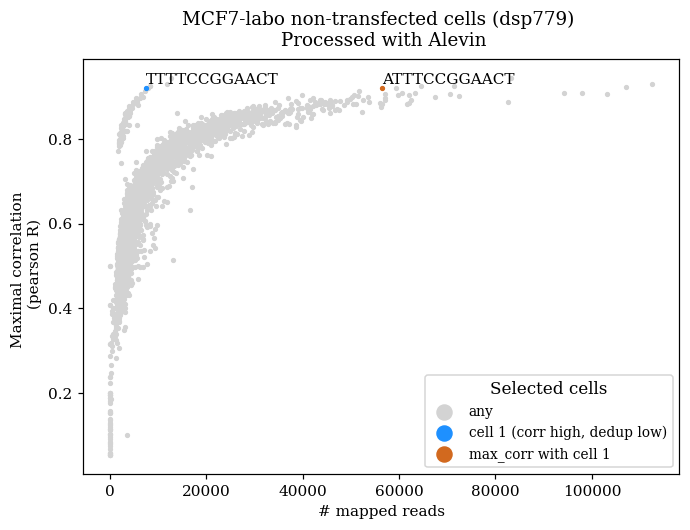

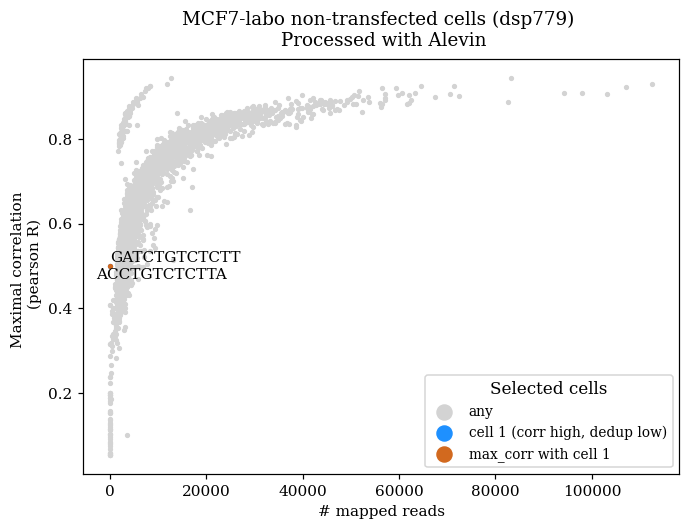

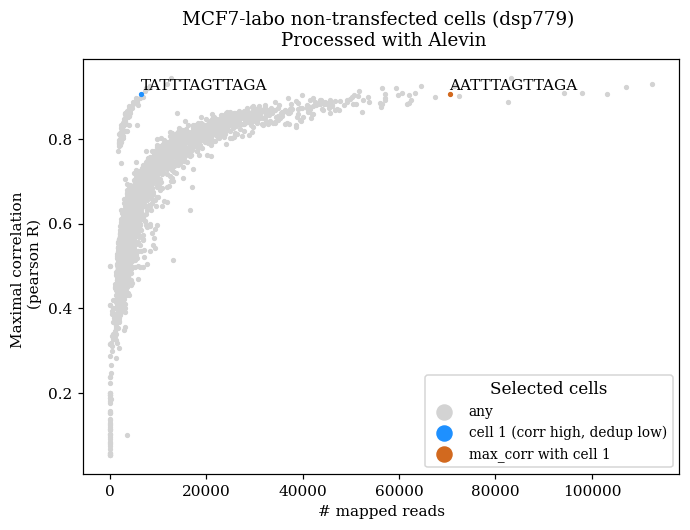

In [113]:
# cb = "CAGTGCCTATCT"


for cb in cbs[:10] :

    i = np.argsort(np.corrcoef(sc.X.toarray())[sc.obs["CB"] == cb].ravel(), axis=0)[-2]

#     sim = [SequenceMatcher(None, cb, cb2).ratio() for cb2 in sc.obs["CB"]]
#     i_sim = np.argsort(sim)[-2]
#     print(i)
#     print(i_sim)


    texts = []
    select_one = []
    for c in sc.obs["CB"] :
        if c == cb :
            select_one.append("cell 1 (corr high, dedup low)")
        elif c == sc.obs["CB"][i] :
            select_one.append("max_corr with cell 1")
        else :
            select_one.append("any")   
            
    sc.obs["select_one"] = np.array(select_one, dtype=str)


    rnaseq.plotting.scatter(sc.obs["MappedReads"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["select_one"].values,\
                            xlabel = "# mapped reads", ylabel="Maximal correlation \n (pearson R)",\
                            title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                            color_title = "Selected cells", save = f"./figs/nt-reads-max-corr_population-max-corr-{cb}.svg",\
                            palette = {"cell 1 (corr high, dedup low)" : "dodgerblue", "max_corr with cell 1":"chocolate", "any":"lightgray"},\
                            order_color=True)


    for c in sc.obs["CB"] :
        if c == cb :
            texts.append(plt.text(sc.obs["MappedReads"].values[sc.obs["CB"] == cb], sc.obs["max_corr"].values[sc.obs["CB"] == cb], c))
        elif c == sc.obs["CB"][i] :
            texts.append(plt.text(sc.obs["MappedReads"].values[i], sc.obs["max_corr"].values[i], c))
    adjust_text(texts, only_move={'points':'y', 'texts':'y'})
    plt.show()
    


### Whitelist

In [15]:
def get_whitelist(libs) :
    
    barcodes = libs.index
    whitelist = []
    error_dict = {}

    neighbors_mtx = np.empty((len(barcodes), len(barcodes)))  
    for i in range(len(neighbors_mtx)) :
        barcode1 = sc.obs["CB"].values[i]
        neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in barcodes]
    neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = barcodes, index = barcodes, dtype=int)
    
    all_components = connectedComponents(neighbors_mtx)
    # n_components, labels = connected_components(csgraph = csr_matrix(neighbors_mtx), directed=False, return_labels=True)
    
    for component in all_components :
    #for component_idx in range(n_components) :
        
        #component = barcodes[labels == component_idx]
        
        if len(component) == 1 :
            whitelist.append(component[0])
        else :
            absorbed = set([])        
            sorting_df = pd.DataFrame(np.array([libs.loc[component].values.ravel(), neighbors_mtx[component].sum(0)]).T,\
                                      columns = ["total_UMIs", "total_neighbors"], index = component)
            sorted_barcodes = sorting_df.sort_values(by=["total_neighbors", "total_UMIs"], ascending=False).index.values

            for barcode in sorted_barcodes :
                neighbors = neighbors_mtx.index.values[neighbors_mtx[barcode] == 1]
                whitelist.append(barcode)
                error_dict[barcode] = list(neighbors[[n not in absorbed for n in neighbors]])
                absorbed.add(barcode)
                absorbed.update(list(neighbors))
                if len(absorbed) == len(component) :
                    break
    
    return all_components, error_dict, whitelist

In [186]:
sc.obs["raw_cb_freq"] = pd.read_table(f"/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/{genref}/\
{quant_params}/Sample_N701_-_Not_Transfected/alevin/raw_cb_frequency.txt",\
                   header = None, index_col = 0).loc[sc.obs["CB"].values]


In [187]:
sc.obs["raw_cb_freq"]

CB
CTGTCTCTTATA    135513
CATCCGCCAGGA    118614
CTGAACGCCTTG    102809
CTCTTTCTTTCT    148199
CTTCACCACCAA    144134
                 ...  
GCTTGCCCCAGC      2895
CTAAGGGCTCGC      2946
GGCAGCGCAAGC      2954
CAGCAGCGTTAT      2877
CTTGTCCCGGCC      2881
Name: raw_cb_freq, Length: 3994, dtype: int64

In [175]:
sc.obs["raw_cb_freq"]

CB
CTTCACCACCAA    141355
CCCTATCCCTAG    149973
CTCTTTCTTTCT    145582
CATCAGGACATC    139168
AATTTGCCGCTA    155215
                 ...  
CATTTTAGAAAA      2795
CAGCAGCGTTAT      2803
CACGTCAACAAT      2809
CGATTCCGATTG      2807
CCCTTCAGCCCC      2812
Name: raw_cb_freq, Length: 3997, dtype: int64

In [89]:
libs = sc.obs["total_UMIs"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2275 barcodes in the new whitelist


In [1402]:
np.savetxt("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/quant/alevin/human/assembly__GRCh38-hg38/annotation__gencode/gencode_34/trimmed-reads-cutadapt/pc-decoys-k31-1.4.0/custom-whitelist/Sample_N701_-_Not_Transfected/whitelist.txt", w, fmt = '%s')

In [18]:
connected_components[:10]

array([list(['TGGTAACTTGAG', 'TGGTAACTAGAG', 'TGGTAACTAGAA', 'TGGTAACTTGAA', 'TGGTAACTTGAC', 'TGGTAACTAGAC', 'TGGTAACTAGAT', 'TGGTAACTTGAT']),
       list(['AAAACGTCTCAG', 'AAAACGTCTCAA', 'AAAACGTCTCAC', 'AAAACGTCTCAT', 'ATAACGTCTCAA']),
       list(['GGAGGCACCCTT', 'GGAGGCACCCTG', 'GGAGGCACCCTA', 'GGAGGCATCCTA', 'GGAGGCACCCTC']),
       list(['CCGTTATTCGGG', 'CCGTTATTCCGG', 'CCGTTATTCCGA', 'CCGTTATTCCGC', 'CCGTTATTCCGT']),
       list(['AGGTATACGAAG', 'AGGTATACGAAC', 'AGGTATACGAAA', 'AGGTATACGAAT', 'TGGTATACGAAG']),
       list(['AATCCACCGATG', 'AATCCACCGATC', 'AATCCACCGATA', 'AATCCACCGATT']),
       list(['GTCTATTAACAA', 'GTCTATTAACAT', 'GTCTATTAACAG', 'GTCTATTAACAC']),
       list(['AGATCCTTTGTG', 'AGATCCTTTGTC', 'AGATCCTTTGTA', 'AGATCCTTTGTT']),
       list(['AACGACTGTCGG', 'AACGACTGTCGA', 'AACGACTGTCGC', 'AACGACTGTCGT']),
       list(['CGGCTACTTATA', 'CGGCTACTTATC', 'CGGCTACTTATG', 'CGGCTACTTATT'])],
      dtype=object)

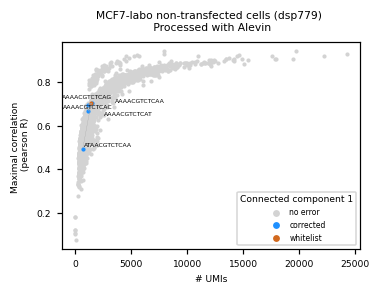

In [2050]:
i = 1

component = connected_components[i]

texts = []
select = []
for barcode in sc.obs["CB"] :
    if barcode in whitelist and barcode in component :
        select.append("whitelist")
    elif barcode in component :
        select.append("corrected")
    else :
        select.append("no error")   

sc.obs["select"] = np.array(select, dtype=str)

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 3, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        color_title = f"Connected component {i}", save = f"./figs/nt-reads-max-corr_population-max-corr-{cb}.svg",\
                        palette = {"corrected" : "dodgerblue", "whitelist" : "chocolate", "no error":"lightgray"},\
                        order_color = ["no error", "corrected", "whitelist"])


for barcode1 in sc.obs["CB"] :
    for barcode2 in cbs :
        if hammingDist(barcode1, barcode2) == 1 :
            x = (sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1], sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode2])
            y = (sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], sc.obs["max_corr"].values[sc.obs["CB"] == barcode2])
            plt.plot(x,y, linewidth = 0.1, color = "darkgray")
    if barcode1 in component :
        texts.append(plt.text(sc.obs["total_UMIs"].values[sc.obs["CB"] == barcode1],\
                              sc.obs["max_corr"].values[sc.obs["CB"] == barcode1], barcode1, fontsize = 4))

adjust_text(texts)

plt.savefig("./cluster_error.pdf")

plt.show()

### Shared UMIs

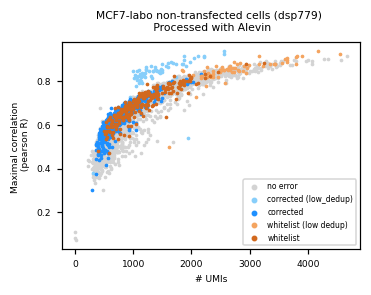

In [794]:
select = []

for barcode in sc.obs["CB"] :
    if barcode in no_error :
        select.append("no error")
    elif barcode in errors_low_dedup :
        select.append("corrected (low_dedup)")
    elif barcode in originals_low_dedup :
        select.append("whitelist (low dedup)")
    elif barcode in errors_normal_dedup :
        select.append("corrected")
    elif barcode in originals_normal_dedup :
        select.append("whitelist")

sc.obs["select"] = np.array(select, dtype=str)

rnaseq.plotting.scatter(sc.obs["NumGenesExpressed"].values, sc.obs["max_corr"].values, s = 2, color = sc.obs["select"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin",\
                        palette = {"corrected (low_dedup)" : "lightskyblue", "whitelist (low dedup)": "sandybrown",\
                                   "corrected" : "dodgerblue", "whitelist": "chocolate", "no error":"lightgray"},\
                        order_color = ["no error",  "corrected (low_dedup)", "corrected", "whitelist (low dedup)", "whitelist"],\
                        save= "./figs/all_errors.pdf"
)

In [672]:
(np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"])) / np.sum(sc.obs["select"] == "whitelist (low dedup)")

57820.94029850746

In [673]:
(np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "corrected (low_dedup)"])) / np.sum(sc.obs["select"] == "whitelist (low dedup)")

11236.641791044776

In [664]:
np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"]) / (np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"]))

0.10243048340437527

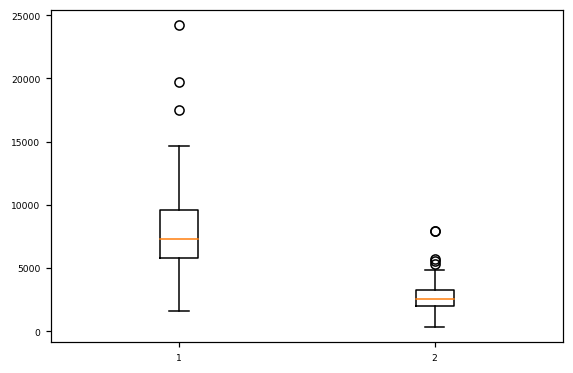

In [797]:
plt.boxplot([sc.obs["total_UMIs"][sc.obs["select"] == "whitelist (low dedup)"], sc.obs["total_UMIs"][sc.obs["select"] == "corrected (low_dedup)"]]);

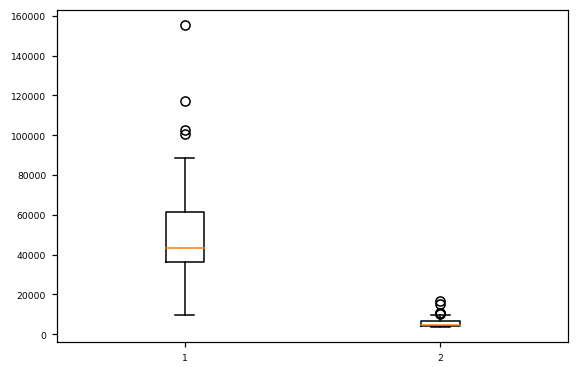

In [798]:
plt.boxplot([sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"], sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"]]);

In [799]:
np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["total_UMIs"][sc.obs["select"] == "corrected (low_dedup)"])

752855.0

In [800]:
np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "whitelist (low dedup)"]) + np.sum(sc.obs["raw_cb_freq"][sc.obs["select"] == "corrected (low_dedup)"])

3874003

In [24]:
x = pd.read_csv("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/raw-fastqs/Sample_N701_-_Not_Transfected/umis.txt", dtype=str, header=None)
index = []
values = []
for s in x[0] :
    index.append(s.split(" ")[0])
    values.append(s.split(" ")[1:])  
x = pd.DataFrame(values, index = index) 

In [28]:
low_dedup_shared_umis = []
normal_dedup_shared_umis = []
random_shared_umis = []


for o,e in zip(get_intended_barcodes(errors_dict, errors_low_dedup)[0], get_intended_barcodes(errors_dict, errors_low_dedup)[1]) :
    n_umis = len(x.loc[o][~x.loc[o].isna()]) #+ len(x.loc[e][~x.loc[e].isna()])
    shared_umis = len(np.intersect1d(x.loc[o][~x.loc[o].isna()], x.loc[e][~x.loc[e].isna()]))
    low_dedup_shared_umis.append(shared_umis/n_umis)

for o,e in zip(get_intended_barcodes(errors_dict, errors_normal_dedup)[0], get_intended_barcodes(errors_dict, errors_normal_dedup)[1]) :
    n_umis = len(x.loc[o][~x.loc[o].isna()]) #+ len(x.loc[e][~x.loc[e].isna()])
    shared_umis = len(np.intersect1d(x.loc[o][~x.loc[o].isna()], x.loc[e][~x.loc[e].isna()]))
    normal_dedup_shared_umis.append(shared_umis/n_umis)

for i in range(len(originals_normal_dedup)):
    cb1,cb2 = np.random.choice(no_error, 2, replace = False)
    n_umis = len(x.loc[cb1][~x.loc[cb1].isna()]) #+ len(x.loc[cb2][~x.loc[cb2].isna()])
    shared_umis = len(np.intersect1d(x.loc[cb1][~x.loc[cb1].isna()], x.loc[cb2][~x.loc[cb2].isna()]))
    random_shared_umis.append(shared_umis/n_umis)

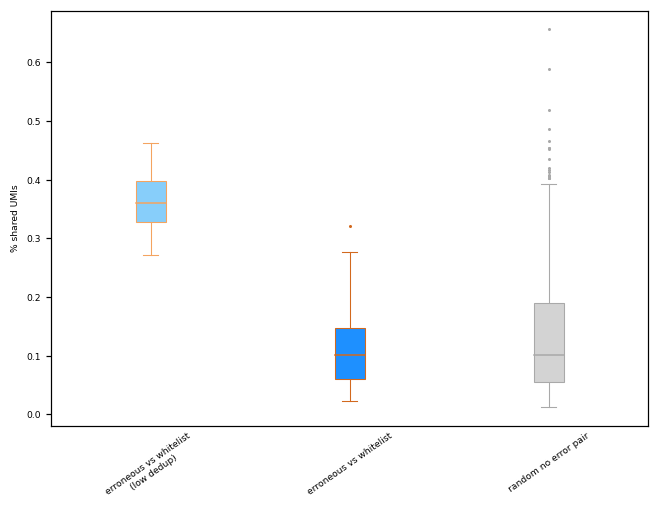

In [29]:
_, ax = plt.subplots(figsize=(7, 5))


bp = plt.boxplot(low_dedup_shared_umis, positions = [0], patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'color' : 'sandybrown', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 capprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 medianprops = {'color' : 'sandybrown', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'sandybrown', 'markeredgecolor':'sandybrown'})

bp = plt.boxplot(normal_dedup_shared_umis, positions = [1], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

bp = plt.boxplot(random_shared_umis, positions = [2], patch_artist = True,\
                 boxprops={'facecolor': 'lightgray', 'color' : 'darkgray', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 capprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 medianprops = {'color' : 'darkgray', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'darkgray', 'markeredgecolor':'darkgray'})

plt.xticks(np.arange(0,3), labels = ["erroneous vs whitelist\n(low dedup)", "erroneous vs whitelist", "random no error pair"])
ax.tick_params(axis='x', rotation = 35, length = 0)

plt.ylabel("% shared UMIs")
plt.savefig("./figs/shared_umis.pdf")

In [33]:
cb = get_intended_barcodes(errors_dict, errors_low_dedup)[1][0]
x.loc[cb][~x.loc[cb].isna()]

0       AAAAGTTA
1       AAAGAGAC
2       AAAGAGGC
3       AAAGCGGG
4       AAAGGCAG
          ...   
1582    TTGGGGAG
1583    TTGGGGGG
1584    TTTAGGGA
1585    TTTCGAGG
1586    TTTGGGAG
Name: TGGTATACGAAG, Length: 1587, dtype: object

In [35]:
np.unique(np.concatenate([ast.literal_eval(x[cb].values[chunk]) for chunk in range(x.shape[0])]))

array(['///A/E/E66EEE////E/E', '///AAE/EAE6EEEEE/EA/',
       '//A/AA/AE6//E6EAEE/E', ..., 'AAAAAEEEEEEEEEEEEEE6',
       'AAAAAEEEEEEEEEEEEEEA', 'AAAAAEEEEEEEEEEEEEEE'], dtype='<U20')

In [70]:
libs = sc.obs["raw_cb_freq"]

connected_components, errors_dict, whitelist = get_whitelist(libs)

print(f"{len(whitelist)} barcodes in the new whitelist")

2275 barcodes in the new whitelist


In [72]:
gm = KMeans(2)
clusters_2 = gm.fit_predict(sc.obs["DedupRate"].values.reshape(-1,1)).astype(object)

means = pd.DataFrame({"cluster" : clusters_2, "dedup" : sc.obs["DedupRate"]}, dtype=float).groupby("cluster").mean()
sorted_cl_labels = means.sort_values(by="dedup").index.astype(int)

for cl, new_cl in zip(sorted_cl_labels, np.sort(sorted_cl_labels)) :
    clusters_2[clusters_2 == cl] = str(new_cl + 1)

sc.obs["cluster_2"] = clusters_2

# s3 = silhouette_score(sc.obs["DedupRate"].values.reshape(-1, 1), sc.obs["cluster_3"].values)
# print(s3)

In [79]:
# originals_mid_dedup = []
errors_mid_dedup = []
# originals_normal_dedup = []
errors_normal_dedup = []

for original in errors_dict.keys():
    for error in errors_dict[original] :
        if sc.obs["cluster_2"].loc[error] == '1':
#             originals_mid_dedup.append(original)
            errors_mid_dedup.append(error)
        else :
#             originals_normal_dedup.append(original)
            errors_normal_dedup.append(error)
            

# no_error = np.concatenate(connected_components[[len(c)==1 for c in connected_components]])
neighbors_mtx = np.empty((len(sc.obs_names), len(sc.obs_names)))  
for i in range(len(neighbors_mtx)) :
    barcode1 = sc.obs_names[i]
    neighbors_mtx[i] = [(hammingDist(barcode1, barcode2) == 1) for barcode2 in sc.obs_names]
neighbors_mtx = pd.DataFrame(neighbors_mtx, columns = sc.obs_names, index = sc.obs_names, dtype=int)

no_error = neighbors_mtx.index.values[neighbors_mtx.sum(1) == 0]

In [62]:
# originals_mid_dedup = []
# errors_mid_dedup = []
# originals_normal_dedup = []
# errors_normal_dedup = []
# others = []

# for barcode in sc.obs_names : 
#     if barcode in whitelist and barcode not in errors_dict.keys() :
#         others.append(barcode)
#     elif barcode in whitelist and sc.obs["cluster_2"].loc[barcode] == '1' :
#         originals_mid_dedup.append(barcode)
#     elif barcode in whitelist and sc.obs["cluster_2"].loc[barcode] == '2' :
#         originals_normal_dedup.append(barcode)
#     elif barcode not in whitelist and sc.obs["cluster_2"].loc[barcode] == '1' :
#         errors_mid_dedup.append(barcode)
#     elif barcode not in whitelist and sc.obs["cluster_2"].loc[barcode] == '2' :
#         errors_normal_dedup.append(barcode)

In [84]:
import pandas
import ast

del x
sample = "Sample_N701_-_Not_Transfected"
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pandas.read_csv(f"{project_path}/raw-fastqs/{sample}/new_umis.csv")

In [51]:
x.shape

(121, 3996)

In [85]:
mid_dedup_shared_umis = []
normal_dedup_shared_umis = []
random_shared_umis = []


for o,e in zip(get_intended_barcodes(errors_dict, errors_mid_dedup)[0], get_intended_barcodes(errors_dict, errors_mid_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_e) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    mid_dedup_shared_umis.append(shared_umis/n_umis)
    
for o,e in zip(get_intended_barcodes(errors_dict, errors_normal_dedup)[0], get_intended_barcodes(errors_dict, errors_normal_dedup)[1]) :
#     umis_e = ast.literal_eval(x[e].values[0])
    umis_e = np.unique(np.concatenate([ast.literal_eval(x[e].values[chunk]) for chunk in range(x.shape[0])]))
#     umis_o = ast.literal_eval(x[o].values[0])
    umis_o = np.unique(np.concatenate([ast.literal_eval(x[o].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_e) #+ len(umis_o)
    shared_umis = len(np.intersect1d(umis_e, umis_o))
    normal_dedup_shared_umis.append(shared_umis/n_umis)
    
for i in range(len(errors_normal_dedup)):
    cb1,cb2 = np.random.choice(no_error, 2, replace = False)
    umis_cb1 = np.unique(np.concatenate([ast.literal_eval(x[cb1].values[chunk]) for chunk in range(x.shape[0])]))
    umis_cb2 = np.unique(np.concatenate([ast.literal_eval(x[cb2].values[chunk]) for chunk in range(x.shape[0])]))
    n_umis = len(umis_cb1) #+ len(umis_cb2)
    shared_umis = len(np.intersect1d(umis_cb1, umis_cb2))
    random_shared_umis.append(shared_umis/n_umis)

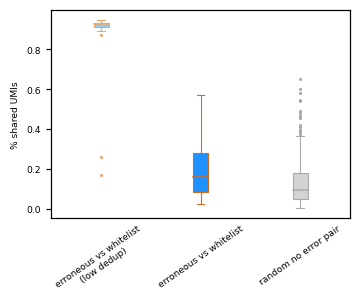

In [86]:
_, ax = plt.subplots(figsize=(3.5, 2.5))


bp = plt.boxplot(mid_dedup_shared_umis, positions = [0], patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'color' : 'sandybrown', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 capprops = {'linewidth': 0.7, 'color':'sandybrown'},\
                 medianprops = {'color' : 'sandybrown', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'sandybrown', 'markeredgecolor':'sandybrown'})

bp = plt.boxplot(normal_dedup_shared_umis, positions = [1], patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'color' : 'chocolate', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 capprops = {'linewidth': 0.7, 'color':'chocolate'},\
                 medianprops = {'color' : 'chocolate', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'chocolate', 'markeredgecolor':'chocolate'})

bp = plt.boxplot(random_shared_umis, positions = [2], patch_artist = True,\
                 boxprops={'facecolor': 'lightgray', 'color' : 'darkgray', 'linewidth': 0.7},\
                 whiskerprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 capprops = {'linewidth': 0.7, 'color':'darkgray'},\
                 medianprops = {'color' : 'darkgray', 'linewidth' : 1},\
                 flierprops = {'marker':'.', 'markersize':2,'markerfacecolor':'darkgray', 'markeredgecolor':'darkgray'})

plt.xticks(np.arange(0,3), labels = ["erroneous vs whitelist\n(low dedup)", "erroneous vs whitelist", "random no error pair"])
ax.tick_params(axis='x', rotation = 35, length = 0)

plt.ylabel("% shared UMIs")
plt.savefig("./figs/shared_umis.pdf")

In [52]:
x = pandas.read_csv(f"{project_path}/raw-fastqs/{sample}/new_phreds.csv")
total_scores = []

for barcode in sc.obs["CB"] :
#     phreds = np.concatenate([ast.literal_eval(chunk) for chunk in x[barcode].values])
    phreds = ast.literal_eval(x[barcode].values[0])[:10000]
    scores = []
    for phred in phreds :
        scores.append([ord(str(s))-33 for s in phred[:12]])
    total_scores.append(np.mean(scores, axis = 0))

total_scores = np.array(total_scores)

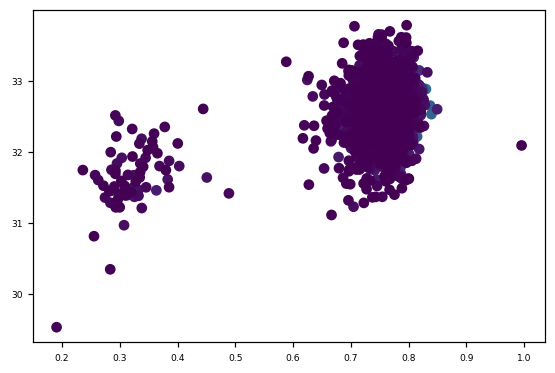

In [54]:
dedup = sc.obs["DedupRate"]
phred = np.mean(total_scores, axis = 1)
plt.scatter(dedup, phred, c=sc.obs["raw_cb_freq"])

In [844]:
 e[-1]

'A'

In [845]:
last_pos_err = []
for error in errors_dict.keys() :
    for e in errors_dict[error] :
        if e[-1] != error[-1] :
            last_pos_err.append(e)
last_pos_err = np.unique(last_pos_err)

In [925]:
x.loc[cb].values

array(['AAAAAGGC', 'AAACCCAC', 'AAACCCGA', ..., None, None, None],
      dtype=object)

In [926]:
last_pos_umi = []
umis_all = []
for cb in errors_normal_dedup :
    umis = 0
    for umi in x.loc[cb].values :
        if umi is not None :
            last_pos_umi.append(umi[0])
            umis +=1
    umis_all.append(umis)
    

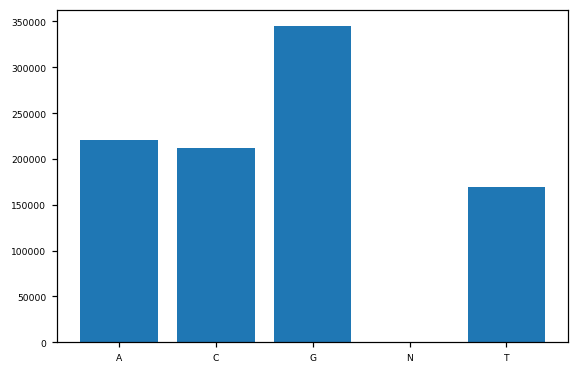

In [927]:
labels = np.unique(last_pos_umi, return_counts=True)[0]
plt.bar(np.arange(len(labels)), np.unique(last_pos_umi, return_counts=True)[1])
plt.xticks(np.arange(len(labels)),labels);

In [842]:
last_pos_umi = []
umis_all_normal = []
for cb in errors_low_dedup :
    umis = 0
    for umi in x.loc[cb] :
        if umi is not None :
            last_pos_umi.append(umi[-1])
            umis +=1
    umis_all_normal.append(umis)

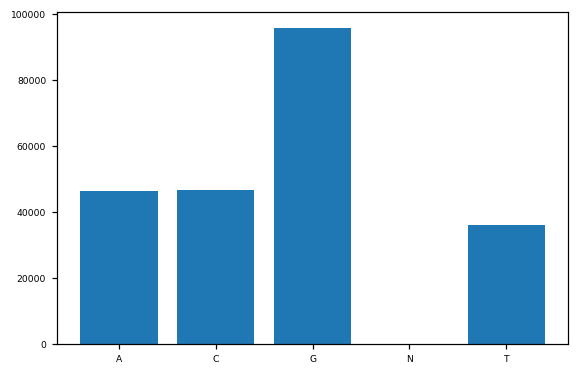

In [843]:
labels = np.unique(last_pos_umi, return_counts=True)[0]
plt.bar(np.arange(len(labels)), np.unique(last_pos_umi, return_counts=True)[1])
plt.xticks(np.arange(len(labels)),labels);

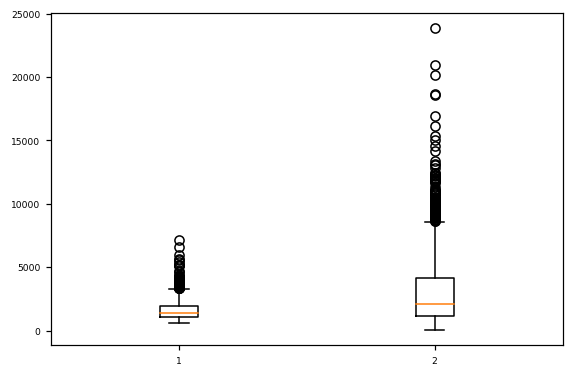

In [790]:
plt.boxplot([umis_all, umis_all_normal]);

In [750]:
tfrac = []
for cb in last_pos_err :
    umis = 0
    tumis=0
    for umi in x.loc[cb] :
        umis+=1
        if umi is not None and umi[-1] == 'T':
            tumis+=1
    tfrac.append(tumis/umis)

In [751]:
tfrac_normal = []
for cb in np.setdiff1d(sc.obs_names, last_pos_err) :
    umis = 0
    tumis=0
    for umi in x.loc[cb] :
        umis+=1
        if umi is not None and umi[-1] == 'T':
            tumis+=1
    tfrac_normal.append(tumis/umis)

In [748]:
np.setdiff1d(sc.obs_names, last_pos_err).shape

(2355,)

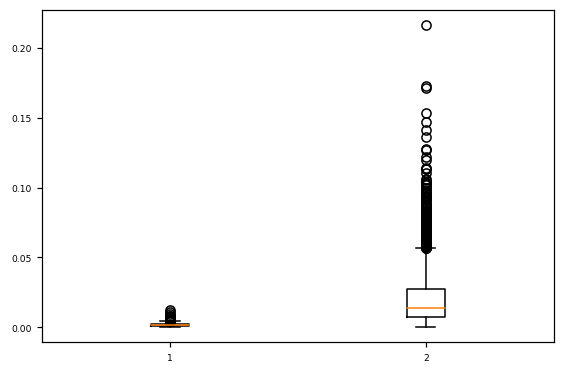

In [752]:
plt.boxplot([tfrac, tfrac_normal]);

### Sequencing errors

In [35]:
x = pd.read_csv("/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779/raw-fastqs/Sample_N701_-_Not_Transfected/phreds.txt",\
                delimiter=" ", index_col=0, header=None, dtype=str, engine='python') 
x = x.drop_duplicates()

total_scores = []

for barcode in sc.obs["CB"] :
    phreds = x.loc[barcode][~x.loc[barcode].isna()]
    scores = []
    for phred in phreds :
        scores.append([ord(str(s))-33 for s in phred[:12]])
    total_scores.append(np.mean(scores, axis = 0))

total_scores = np.array(total_scores)

In [24]:
import pandas
import ast
sample = "Sample_N705_-_ER1"
project_path = "/home/arion/davidm/Data/datasets/raw/private/RNA-seq/sc/dsp779"
x = pandas.read_csv(f"{project_path}/raw-fastqs/{sample}/new_phreds.csv")

In [25]:
x

GCCCGTATGCCA  \
0    ['AA6AAEEAE/AEEE/EA6E6', 'AAAA6EEEEEEEEAEEEEEE...   
1    ['AAAAAAEAEEEEEEEEEEEE', 'AAAA<EEEEEEE/A6EEEEE...   
2    ['AAAAAEEEEEEEEEEEAEEE', '/AAAAEEEEEEEEEEEE/EE...   
3    ['AAAAAAEEEEE6EEEEEEEE', 'AAAAAEEE/AEEEEEEEEEE...   
4    ['/6AA6E6//EEEEA66EEEE', 'AAAAAEEEEEEEEEEEEEEE...   
..                                                 ...   
162  ['AAA/A6E66EEEEAEEEEA/', 'AAAAA/E6EAEEEE/EEEEA...   
163  ['AAAAAEEEEEAE6EEEEEEE', 'AA//AEEEEE/EEEE//<AA...   
164  ['AAAAAEEEEEEEEEEEEEEE', '/AAAAEEE66EE6EEEAEAE...   
165  ['/AA/A/EEEE/EEE/EEAAA', 'AAAAAEEEEAEEEEEEEEEE...   
166  ['AAAAAEEEEEEEEEEEEEEE', 'AAAAAEEEA/EEAEEE6EEE...   

                                          TGACAGAGGGAA  \
0    ['AAAAAEEAEEEEEEEEEEEE', 'AAAAAEEAEEEEEEEEEEEE...   
1    ['AAAAAEEEEEE/AEAEE/EE', '//AAAEE/EE6EE/EE6E6E...   
2    ['AAA/AAEEEEEEEEEEEEEE', '/AAAA/A66AEEAEA/E6/E...   
3    ['/A//AEEE6EEEEEE6EEEE', '/AAAAEEEEEEEEEEEEEE/...   
4    ['/6//AAE/A/6EEEEEEEEE', '/AAAAEA6///EE/EAA/E6...   
..                                                 ...   
162  ['/A6/AA6///EEAEA6A/E/', 'AAAAA6EE6//6E/E/EE6/...   
163  ['/AAA6E6AE6EAEEEEEE<E', 'AA6AAEEEEE/EE6AEEEEE...   
164  ['AAAAAEAEEEEEEEEE6EEE', 'AA/AA6EAEE66EE6/AEEA...   
165  ['AAA/AEAE/EEE66/EEEEE', 'AAAAAEEEEEAEEEEEEEEE...   
166  ['/6<66/AE6/E/EEE6/EE/', '//A/AA6EE6EEEEEA/EEE...   

                                          CACTTAATATGA  \
0    ['AAAAA6EEEEEAEEEEEEEE', 'AAAAAEEEEEEEEEEEEEEE...   
1    ['AA/AAEEE6EEEEEEEEEEE', 'AAAA6EEE66EEEAEEEE66...   
2    ['AAAAAEE6EEEEEEAEEEEE', 'AAAAAE6EE/EEAEEEEEEE...   
3    ['AAAAAAEEAEEEEEEEEEEE', 'AAA6A6EEEEE6EEEAEEEE...   
4    ['//AAA/E6EEEEEE/AAEEE', 'A/AAAEAEEEEEEEEEEAEA...   
..                                                 ...   
162  ['/AAAAAEEEE6EEEEEEEEA', 'AAAAAEE/EE/A/AEEEE/E...   
163  ['AAAAAAEEAEEAEEEEEEEE', 'AAA/AA/E////AEEA/AEE...   
164  ['A/A/A6EA/E6AEEA/AE6E', 'AAAAA<EE6EEEEEEEEEEA...   
165  ['AAAAA/EEEEEEEEEEEAEE', '/A/AA6EEEEAEEEE6EEEE...   
166  ['A/AAAEEE6EEEEEEEEE6E', 'AAAAA/EEEEEEAEEEEEEE...   

                                          CCGCGCTTGAGC  \
0    ['AAAAAEEEEEEAAEEEEEE/', 'AAAAAEAEE/EEEE6EEEEE...   
1    ['AAAAAEEEEEEEEEEEEEEE', '6AAAAEAEEE/AEEEEEEEE...   
2    ['AAAAAEAEEEEEEEEEEEEE', 'AAAAAEEEEEEEAEEEEEA/...   
3    ['AAAAAAEE666EEEEAE//E', '/AAAA/EEE6EEEEEEEEEE...   
4    ['AAAAAEEEEAEEEEEEEEEE', 'AAAAAEEEEEEEEEEEEEEE...   
..                                                 ...   
162  ['AAAAAAAAEEEE6EEAEEEE', 'AAAAAEEEEEEEEEEEEEEE...   
163  ['AAAAAEAEE6EEEEAEEEEE', '/AA/A//AEE/EEEEE6EEE...   
164  ['AAAAAEEEEEEEEEEAEEEE', 'AAAAAE6EEEEEAEEEEEEE...   
165  ['AAAAAEEEEEEEEEEEE/EE', 'AAAAAEEEEEEEEEEEEEEE...   
166  ['AAAAAEA/E/E/E///A/EE', 'AAAAAEEEEEEEEEEEEEAE...   

                                          CTAAAGAACTTG  \
0    ['AAAAAE6EAEEEEEEEEEEE', 'AAAAAEEEEEE66/EEEEAE...   
1    ['AAAAAE6EEEEEEEEEEEAE', 'AAAAAEEEEEEEEEEAEEAE...   
2    ['AA6AAEEEAEEEEEEEEEEE', 'AAAAAEEEEEEEEAEEEEEE...   
3    ['AA6AAEEEEEEEEEEEEEEE', 'AAAAAEEEEEEEEEEEEEE/...   
4    ['AAAA6AEEEEEEEEEA/EEE', 'AAAAAEEEEEEEEEEEEAEE...   
..                                                 ...   
162  ['/AAAAEE6EEEEEEEEEEEE', 'AA/AA/6EEEAE6E6E/EEE...   
163  ['AAAA6EEEEEEEEEEEEEEE', 'AAAAAEEEEAEEEEEEEEE/...   
164  ['AAAAAEEE//E/AEEEEEEE', 'AAA/AEEEEEEEEEEEEEEA...   
165  ['AAAAAEEEEEEEEEEEEEEE', '/A/AAEEAEE/EEEEEEEE6...   
166  ['AAAAAEEEAAEEEAEEAEEE', 'AAAAAEEEEEEEEEEEEEEE...   

                                          GGCTCCCTCTAT  \
0    ['AAAAAEAEEEEEEEEEEEEE', 'AAAAAEEE/EEA6E/EEEEA...   
1    ['A/AAAEEEEEEEEEEEEEEE', 'AAAAAEE/EEEEEEEEEEEE...   
2    ['AAAAAEEAAEEEEEEAEEEE', 'AAAAAEEEEEEEEEEEEEEE...   
3    ['AAAAAEEEEEEEEEEEEEAE', 'A//AA/AEAE6E//EAAEEE...   
4    ['AAAAAAAEAA6EEEEAE//E', 'AAA6AAEEEEEEEEEAEEEE...   
..                                                 ...   
162  ['6AAAAEEEEEEAEEEEEEEE', 'AAAAAEEEAEEEEEEEEEEE...   
163  ['AAAAAEEAEEEEEEEEEEEE', 'AAAAAEEEEEEEEEEEEEEE...   
164  ['AAAAAAAEEEEEEEEEEEEE', 'AAAA

In [ ]:
total_scores = []

for barcode in sc.obs["CB"] :
    phreds = np.concatenate([ast.literal_eval(chunk) for chunk in x[barcode].values])
    scores = []
    for phred in phreds :
        scores.append([ord(str(s))-33 for s in phred[:12]])
    total_scores.append(np.mean(scores, axis = 0))

total_scores = np.array(total_scores)

In [36]:
corrected_low_dedup_phreds = np.array(total_scores[(sc.obs["select"] == "corrected (low_dedup)")])
corrected_normal_dedup_phreds = np.array(total_scores[(sc.obs["select"] == "corrected")])
random_phreds = np.array(total_scores[(sc.obs["select"] == "no error")])

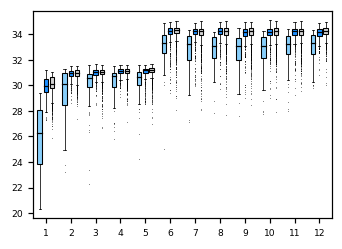

In [43]:
ax = plt.subplots(figsize=(3.5, 2.5))

flierprops = {'marker':'.', 'markersize':1, 'markeredgecolor':'none', 'markerfacecolor':'black'}
medianprops = {'color':'black', 'linewidth':0.8}
whiskerprops = {'linewidth': 0.5}
capprops = {'linewidth': 0.5}


bp = plt.boxplot(corrected_low_dedup_phreds, positions = np.arange(0,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'lightskyblue', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

bp = plt.boxplot(corrected_normal_dedup_phreds, positions = np.arange(1,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'dodgerblue', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

bp = plt.boxplot(random_phreds, positions = np.arange(2,48,4), widths = 0.7, patch_artist = True,\
                 boxprops={'facecolor': 'lightgray', 'linewidth': 0.7},\
                 flierprops=flierprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops)

plt.xticks(np.arange(1,48,4), labels = np.arange(1,13))
plt.xlim(-1, 47);

### Alevin trimmed custom whitelist

In [1608]:
sc = rnaseq.readwrite.read_raw(project_id  = project, quant_tool = "alevin", samples = sample, genes_id = "ensembl_gene_id", quant_params = quant_params_trimmed_wh, genref = genref, cdna = "3' tag", exp = "sc")

rnaseq.setup.annotate_samples(sc, samples_annot_name = "samples", samples_annot = new_sample_name, ow = True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "total_UMIs", samples_annot = sc.X.toarray().sum(1).ravel(), ow=True)
rnaseq.setup.annotate_samples(sc, samples_annot_name = "#_genes", samples_annot = (sc.X.toarray() != 0).sum(1).ravel())
rnaseq.setup.annotate_samples(sc, samples_annot_name = "mt_frac")

# rnaseq.pp.filter_cells(sc, n_counts_min = 1500, mt_max = 0.05, inplace = True)

rnaseq.setup.annotate_samples(sc, samples_annot_name = "max_corr", ow=True)

Using BioMart Ensembl Genes 100 hsapiens_gene_ensembl for gene annotations.
Annotating samples...
Annotating total_UMIs...
Annotating #_genes...
Annotating mt_frac...
Annotating chromosome_name using Biomart (Ensembl Genes 100, 'hsapiens_gene_ensembl')...
Annotating max_corr...
Normalization by total UMIs...
Log2 + 1 tranformation...


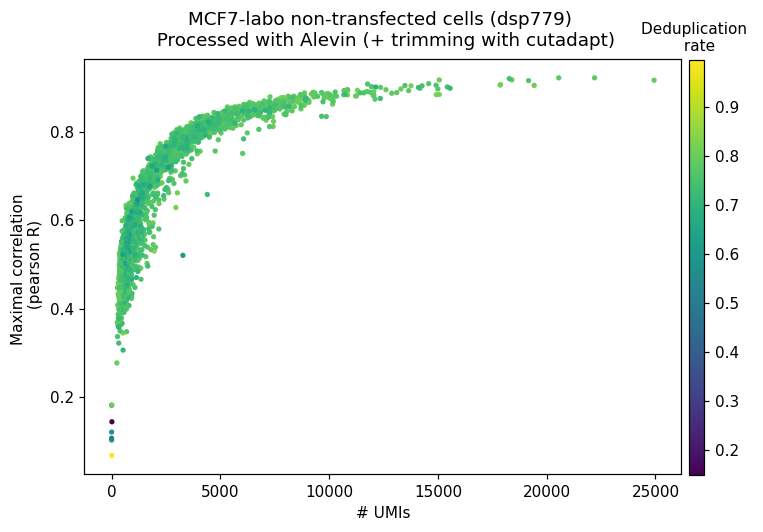

In [1405]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["DedupRate"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin (+ trimming with cutadapt)",\
                        color_title = "Deduplication \n rate", save = "./figs/trimmed-nt.svg")

In [1610]:
barcodes = sc.obs["CB"].values
sc.obs["n_neighbors"] = [np.sum([hammingDist(cb1, cb2) == 1 for cb2 in barcodes]) for cb1 in barcodes]

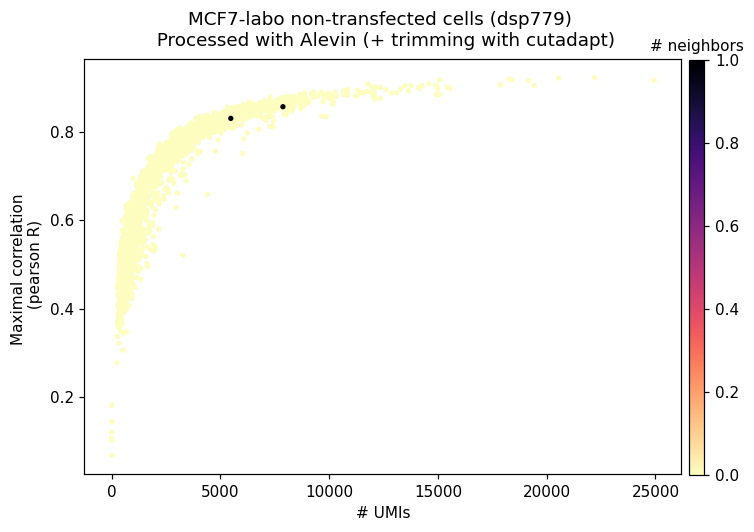

In [1611]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["n_neighbors"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin (+ trimming with cutadapt)",\
                        color_title = "# neighbors", order_color="ascending", palette = "magma_r", save="./figs/nn-dpt.png")

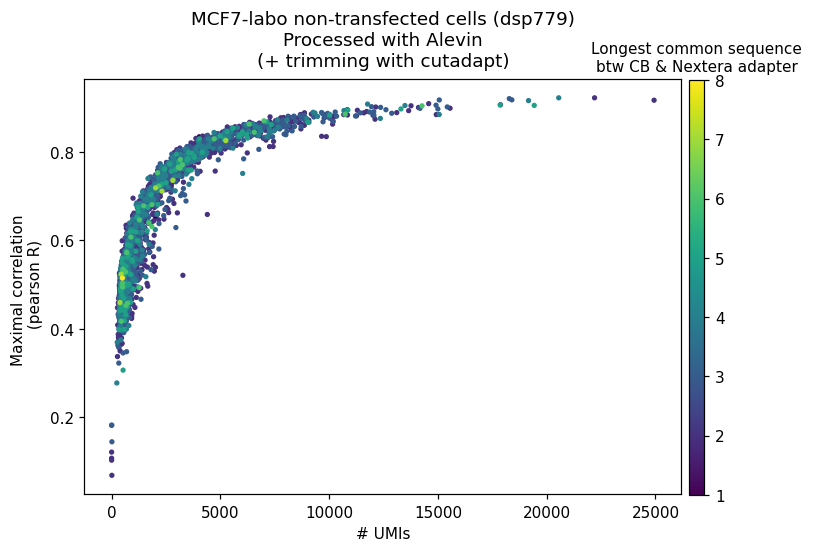

In [1613]:
adapter = "CTGTCTCTTATACACATCTC"

sc.obs["adapter-in-cb"] = [len(longest_common_substring(adapter, cb)[0][0]) for cb in sc.obs["CB"]]

rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["adapter-in-cb"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)", \
                        title = "MCF7-labo non-transfected cells (dsp779)\nProcessed with Alevin\n(+ trimming with cutadapt)",\
                        color_title = "Longest common sequence\nbtw CB & Nextera adapter", order_color = "ascending")

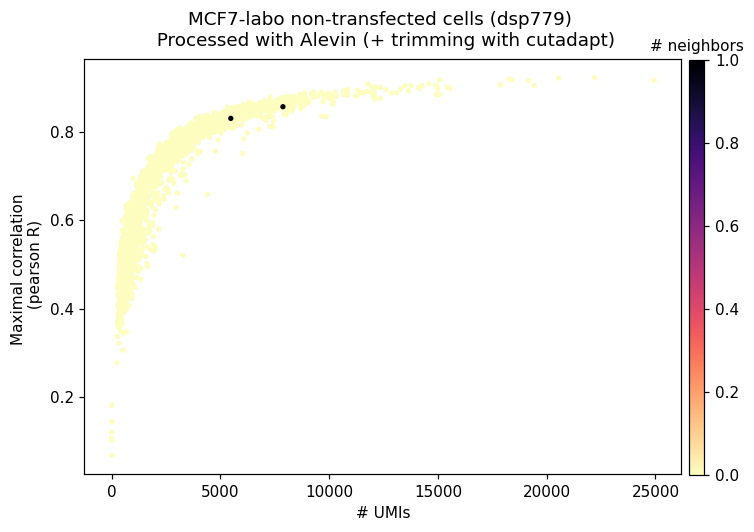

In [1611]:
rnaseq.plotting.scatter(sc.obs["total_UMIs"].values, sc.obs["max_corr"].values, s = 6, color = sc.obs["n_neighbors"].values,\
                        xlabel = "# UMIs", ylabel="Maximal correlation \n (pearson R)",\
                        title = "MCF7-labo non-transfected cells (dsp779) \n Processed with Alevin (+ trimming with cutadapt)",\
                        color_title = "# neighbors", order_color="ascending", palette = "magma_r", save="./figs/nn-dpt.png")

In [6]:
%%bash
tar czf ./figs.tar.gz ./figs/*.svg